In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys
import matplotlib.pyplot as plt

## Virginia

Election results from Virginia Department of Elections (https://historical.elections.virginia.gov/)

RDH Note: Data found here https://apps.elections.virginia.gov/SBE_CSV/ELECTIONS/ELECTIONRESULTS/2020/

## Election Results Processing

Absentee ballots and provisional votes were reported at the county or city level throughout the state. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.

## Shape Files and Processing

Precinct shapefile primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. A significant number of precincts throughout the state have been replaced with the U.S. Census Bureau's 2020 Redistricting Data Program final release. Virginia election reports sometimes include precinct splits that are obsolete or unused for the given election cycle. These have been omitted. In cases where voters were assigned to the wrong district the de facto precinct split has been included for that election.

The borders of Chesapeake, Norfolk, Suffolk, Virginia Beach reflect de facto misalignments that were not corrected before 2020.

The following modifications were made to recreate the 2020 precinct boundaries.

Albemarle: Add Mechums River to match county GIS shapefile

Alexandria City: Add Alex Renew, Olympus Condo; Adjust Lee Center/Lyles Crouch, Beatley Library/Cameron Station to match county GIS shapefile

Arlington: Adjust Gunston/Oakridge to match county GIS shapefile

Bristol City: Adjust Ward 2/Ward 4 to match description in municipal code

Charles City County: Adjust District 1/District 2 boundary to match county code

Chesapeake City: Split, merge, or adjust 26 precincts to match PDF maps of citywide realignment

Chesterfield: Split Iron Bridge/Iron Bridge North, Skinquarter/Magnolia, Winfrees Store/Longhouse, Southside/Ridgedale, Genito/Clover Hill to match county GIS shapefile

Covington City: Realign Ward 1, Ward 2, Ward 3 to match city PDF map and municipal code

Culpeper: Adjust East Fairfax/Brandy Station boundary to match county GIS shapefile

Emporia City: Adjust Precincts 1/7, Precincts 2/5 to match municipal code

Essex: Adjust South Precinct/Central Precinct boundary to match county PDF

Fairfax: Adjust Virginia Run/Bull Run to match county GIS shapefile

Fredericksburg City: Adjust District 1/3 boundaries to match municipal code

Galax City: Adjust North/South precinct boundary to match municipal GIS shapefile

Halifax: Merge South Boston East/West; Adjust Meadville/Republican Grove to match 2011 redistricting PDF map

Hampton City: Add US House District 2 segment of Tyler Precinct to match county PDF; Adjust 6 precincts to reflect correction of border with Newport News City

Hanover: Adjust Blunts/Beaverdam boundary to match county PDF

Henry: Adjust 10 precinct boundaries to align VTDs with county GIS shapefile

Loudoun: Adjust Weller/Ashbrook, Evergreen/Sycolin Creek; Add Goshen Post, Buffalo Trail to match county GIS shapefile

Newport News City: Adjust Sanford/Riverview boundary to match county GIS shapefile; Ajust 12 precincts to reflect correction of border with Hampton City

Norfolk City: Merge Bramblewood into Chesterfield/Ruffner Academy; Adjust Granby/Titustown to match county PDF

Northumberland: Merge subprecincts 3-A and 3-B to match county PDF

Prince William: Split Piney Branch/Bristow Run, Potomac/Williams; Adjust Ben Lomond/Mullen, Freedom/Leesylvania to match county GIS shapefile

Radford City: Split East/New River precincts to match municipal ordinance

Rappahanock: Adjust Sperryville/Washington boundary to match county PDF

Richmond City: Add Precinct 115, 215, 415 to match county GIS shapefile

Richmond County: Adjust Precincts 2-1/3-1 boundary to match description in county ordinance

Roanoke County: Adjust 12 precinct boundaries to match county GIS shapefile

Rockingham: Split East/West Bridgewater to match municipal ordinance; Adjust East Bridgewater to match municipal boundary

Russell: Adjust Daugherty/West Lebanon boundary to match county PDF

Tazewell: Merge Abbs Valley/Bossevain, Adria/Gap Store, Pounding Mill/Wardell, Raven/Richlands;  Adjust nearly all precinct boundaries to align VTDs with county GIS shapefile

Virginia Beach City: Adjust Centerville/Colonial to match county GIS shapefile

Williamsburg City: Revise Matoaka/Stryker to match municipal PDF map and municipal code

Wise: Adjust Big Stone Gap/East Stone Gap boundary to match county GIS shapefile

Wythe: Adjust West Wytheville/East Wytheville boundary to match county GIS shapefile

York: Adjust Dare/Harwoods Mill to match county GIS shapefile

## Races

 - G20PREDBID - Joseph R. Biden (Democratic Party)
 - G20PRERTRU - Donald J. Trump (Republican Party)
 - G20PRELJOR - Jo Jorgensen (Libertarian Party)
 - G20PREOWRI - Write-in Votes


 - G20USSDWAR - Mark Robert Warner (Democratic Party)
 - G20USSRGAD - Daniel Mac Arthur Gade (Republican Party)
 - G20USSOWRI - Write-in Votes
 
 ## RDH Note
 
 - Elections results joining found an error in the Galax City Precincts. VEST has East, South, and North Galax City. While the statewide results have West, South and East.
 - The following precincts have no VEST documentation about how they were split by VEST (into 2 precincts). We assume that VEST has split these precincts according to the county SOV from the Virginia's Department of Elections, but we are not sure. RDH has combined each of these precincts into a singular precinct in order to verify election results from the VEST data. 
- 103 - travelers rest spotsylvania county
- 104 - titustown norfolk city
- 110 - buckland mills prince william county
- 112 - burke-nickens prince william county
- 202 - jamestown b james city county
- 210 - penn prince william county
- 211 - palmer newport news city
- 215 - tyler hampton city
- 218 - kiln creek newport news city
- 302 - john f kennedy suffolk city
- 304 - mount olivet henry county
- 312 - triangle prince william county
- 402 - parkside spotsylvania county
- 404 - booker t washingtonsuffolk city
- 504 - lake cohoon suffolk city
- 504 - roberts d james city county
- 505 - dyers store henry county
- 513 - saint albans fairfax county
- 602 - olde towne suffolk city
- 609 - king prince william county
- 700 - fairfax court fairfax county
- 702 - brents mill spotsylvania county
- 703 - fairview spotsylvania county
- 704 - gayle spotsylvania county

- Write-in votes were not able to be validated


In [2]:
vest_shp = gp.read_file("./raw-from-source/vest/va_2020.shp", crs='3857')

In [3]:
vest_shp.shape

(2477, 12)

In [4]:
vest_shp.head()

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREOWRI,G20USSDWAR,G20USSRGAD,G20USSOWRI,geometry
0,001,Accomack County,000101,Chincoteague,837,1618,29,2,915,1563,3,"POLYGON Z ((-75.42507 37.89957 0.00000, -75.42..."
1,001,Accomack County,000201,Atlantic,321,657,11,2,357,644,0,"POLYGON Z ((-75.59978 37.87664 0.00000, -75.59..."
2,001,Accomack County,000202,Greenbackville,516,1091,18,0,539,1054,0,"POLYGON Z ((-75.49919 37.93416 0.00000, -75.49..."
3,001,Accomack County,000301,New Church,1013,667,14,2,1003,638,2,"POLYGON Z ((-75.64987 37.92702 0.00000, -75.64..."
4,001,Accomack County,000401,Bloxom,307,462,8,0,306,447,0,"POLYGON Z ((-75.71556 37.87513 0.00000, -75.71..."


<AxesSubplot:>

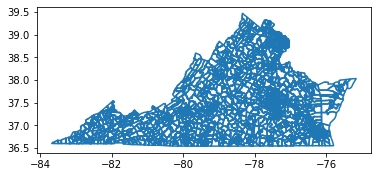

In [5]:
vest_shp.boundary.plot()

<AxesSubplot:>

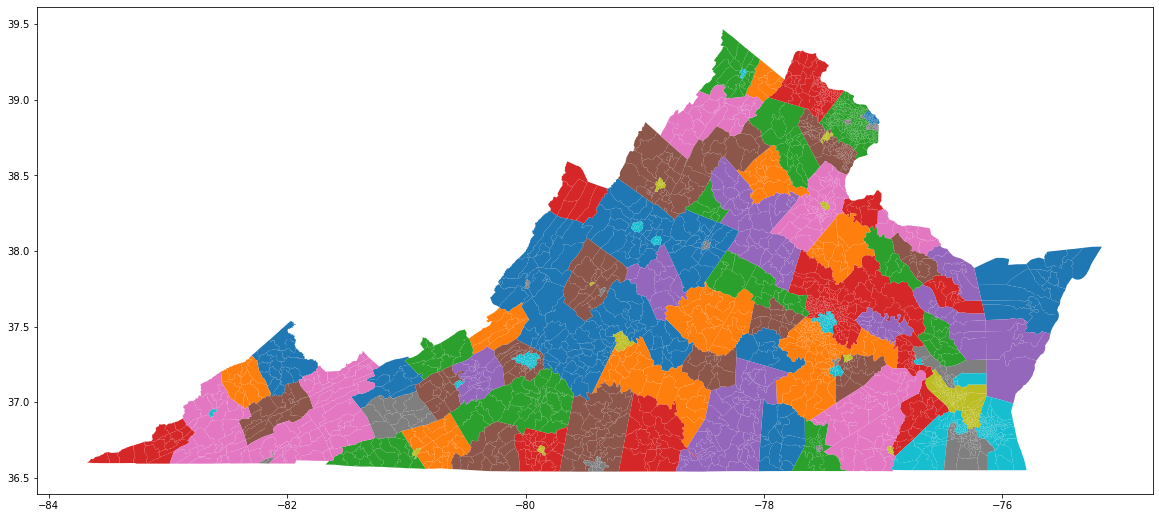

In [6]:
vest_shp.plot(column='COUNTYFP', figsize=(20,20))

In [7]:
list(vest_shp['VTDST'])

['000101',
 '000201',
 '000202',
 '000301',
 '000401',
 '000402',
 '000403',
 '000501',
 '000502',
 '000602',
 '000801',
 '000802',
 '000803',
 '000901',
 '000203',
 '000306',
 '000105',
 '000302',
 '000305',
 '000401',
 '000402',
 '000405',
 '000406',
 '000499',
 '000501',
 '000502',
 '000504',
 '000599',
 '000603',
 '000307',
 '000601',
 '000602',
 '005101',
 '005103',
 '005201',
 '005401',
 '005202',
 '005301',
 '005302',
 '005402',
 '005501',
 '005502',
 '005601',
 '005701',
 '000101',
 '000201',
 '000301',
 '000401',
 '000501',
 '000101',
 '000102',
 '000103',
 '000201',
 '000202',
 '000301',
 '000302',
 '000303',
 '000401',
 '000402',
 '000501',
 '000102',
 '000201',
 '000302',
 '000501',
 '000502',
 '000001',
 '000002',
 '000003',
 '000015',
 '000048',
 '000004',
 '000014',
 '000005',
 '000027',
 '000006',
 '000024',
 '000007',
 '000025',
 '000036',
 '000008',
 '000009',
 '000026',
 '000035',
 '000010',
 '000019',
 '000038',
 '000044',
 '000011',
 '000041',
 '000012',
 '000021',

In [8]:
vest_shp = vest_shp.iloc[:,:-1]
vest_shp

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREOWRI,G20USSDWAR,G20USSRGAD,G20USSOWRI
0,001,Accomack County,000101,Chincoteague,837,1618,29,2,915,1563,3
1,001,Accomack County,000201,Atlantic,321,657,11,2,357,644,0
2,001,Accomack County,000202,Greenbackville,516,1091,18,0,539,1054,0
3,001,Accomack County,000301,New Church,1013,667,14,2,1003,638,2
4,001,Accomack County,000401,Bloxom,307,462,8,0,306,447,0
...,...,...,...,...,...,...,...,...,...,...,...
2472,800,Suffolk City,000602,Olde Towne (CD 3),609,174,11,2,613,172,0
2473,800,Suffolk City,000504,Lake Cohoon (CD 4),594,1182,24,5,654,1156,0
2474,800,Suffolk City,000302,John F Kennedy (CD 4),1111,54,13,5,1082,58,5
2475,800,Suffolk City,000504,Lake Cohoon (CD 3),143,325,2,2,149,317,0


## Load the Statewide Election Results File

In [9]:
va_20 = pd.read_csv("./raw-from-source/source/2020 November General.csv", index_col=False)

In [10]:
va_20

,CandidateUid,FirstName,MiddleName,LastName,Suffix,TOTAL_VOTES,Party,WriteInVote,LocalityUid,LocalityCode,...,PrecinctName,DistrictUid,DistrictType,DistrictName,OfficeUid,OfficeTitle,ElectionUid,ElectionType,ElectionDate,ElectionName
0,NaN,NaN,NaN,WRITE IN VOTES,NaN,29.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,# AB - Central Absentee Precinct,{56CEFA54-D3FE-458F-A181-8AC83CFEEC9E},Town,ACCOMAC,{7B286F5B-546F-4398-BD7D-D20EFD9FD021},Member Town Council - Accomac,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,11/3/2020 0:00,2020 November General
1,NaN,NaN,NaN,WRITE IN VOTES,NaN,2.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,# AB - Central Absentee Precinct,{05BBA99B-D90A-4413-A142-8163C13316D2},Town,PARKSLEY,{5A7D053B-A5B5-43B2-91A7-4D92D7690888},Member Town Council - Parksley,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,11/3/2020 0:00,2020 November General
2,NaN,NaN,NaN,WRITE IN VOTES,NaN,3.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,# AB - Central Absentee Precinct,{8967B9DD-E94E-4964-A919-30E520165984},Congressional,2,{72E39A01-83E7-4A1F-A743-8A0241C16F23},Member House of Representatives,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,11/3/2020 0:00,2020 November General
3,NaN,NaN,NaN,WRITE IN VOTES,NaN,6.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,# AB - Central Absentee Precinct,{41EFCFD5-80FB-4BA5-B46B-661AB2DAF560},Town,MELFA,{B5646808-5255-423A-BF40-118DF4B982D8},Mayor - Melfa,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,11/3/2020 0:00,2020 November General
4,NaN,NaN,NaN,WRITE IN VOTES,NaN,14.0,NaN,1,{15B7E141-2D1D-44C2-A50A-AAE021BC9B7D},1,...,# AB - Central Absentee Precinct,{D2CDAB24-224B-4B44-8416-E3AC7529669E},Town,BLOXOM,{FD903D95-6329-45C0-A66E-A77B552F063A},Mayor - Bloxom,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,11/3/2020 0:00,2020 November General
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36882,{FE077034-3862-4367-9F16-1C055267A2E6},LINCOLN,WILLIAM,JONES,NaN,313.0,Independent,0,{6A6AF5ED-2E2D-4A33-9248-01869C1C7DEA},840,...,402 - ROLLING HILLS,NaN,NaN,NaN,{11DA35D4-30DA-4798-8D6E-09A2D07A83AC},Member School Board At-Large,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,11/3/2020 0:00,2020 November General
36883,{F1F207CF-A1F8-4487-B2F9-729360681A55},MARIE,SHEARA,IMOH,NaN,323.0,Independent,0,{6A6AF5ED-2E2D-4A33-9248-01869C1C7DEA},840,...,402 - ROLLING HILLS,NaN,NaN,NaN,{11DA35D4-30DA-4798-8D6E-09A2D07A83AC},Member School Board At-Large,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,11/3/2020 0:00,2020 November General
36884,{6B91E7F2-9867-4EC4-AB43-C82EEE4D15F6},MARK,ROBERT,WARNER,NaN,248.0,Democratic,0,{6A6AF5ED-2E2D-4A33-9248-01869C1C7DEA},840,...,402 - ROLLING HILLS,{BF50CB62-3AFF-41FC-96C1-483EA47576E0},Congressional,10,{290B1F88-4C66-46CD-94E6-7CB8BC4F01D0},Member United States Senate,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,11/3/2020 0:00,2020 November General
36885,{35C74F55-DE5B-4DCD-860A-9D00025A3758},PHILLIP,LEE,MILSTEAD,NaN,255.0,Democratic,0,{6A6AF5ED-2E2D-4A33-9248-01869C1C7DEA},840,...,402 - ROLLING HILLS,{0663C76D-155E-46F7-99EE-B9E90509176F},Election,FOURTH WARD,{25B12576-173D-496B-BE71-8D64B58182CF},Member City Council,{5BEEA701-3272-4452-AE08-BFDF24F0D41C},General,11/3/2020 0:00,2020 November General


In [11]:
va_20.columns

Index(['CandidateUid', 'FirstName', 'MiddleName', 'LastName', 'Suffix',
       'TOTAL_VOTES', 'Party', 'WriteInVote', 'LocalityUid', 'LocalityCode',
       'LocalityName', 'PrecinctUid', 'PrecinctName', 'DistrictUid',
       'DistrictType', 'DistrictName', 'OfficeUid', 'OfficeTitle',
       'ElectionUid', 'ElectionType', 'ElectionDate', 'ElectionName'],
      dtype='object')

## Clean Up the Elections Results

In [12]:
#filter needed columns
filtered_20 = va_20[['FirstName','MiddleName','LastName','TOTAL_VOTES','PrecinctName','LocalityName','OfficeTitle']]

In [13]:
#combine candidate name columns
filtered_20['cand_name'] = filtered_20['FirstName'].astype(str) + " " + filtered_20['MiddleName'].astype(str) + " " + filtered_20['LastName'].astype(str)
list(filtered_20['cand_name'])

<ipython-input-13-a4bab8ed403b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_20['cand_name'] = filtered_20['FirstName'].astype(str) + " " + filtered_20['MiddleName'].astype(str) + " " + filtered_20['LastName'].astype(str)


['nan nan WRITE IN VOTES',
 'nan nan WRITE IN VOTES',
 'nan nan WRITE IN VOTES',
 'nan nan WRITE IN VOTES',
 'nan nan WRITE IN VOTES',
 'nan nan WRITE IN VOTES',
 'nan nan WRITE IN VOTES',
 'nan nan WRITE IN VOTES',
 'nan nan WRITE IN VOTES',
 'nan nan WRITE IN VOTES',
 'nan nan WRITE IN VOTES',
 'nan nan WRITE IN VOTES',
 'nan nan WRITE IN VOTES',
 'nan nan WRITE IN VOTES',
 'ALEXIS nan KOMARIDIS',
 'BARRY CHANCE FREY',
 'BILLYE DUNCAN CUSTIS',
 'BRIAN AULDEN CORBIN',
 'BRIAN BENJAMIN LANGLEY',
 'CAROL ELIZABETH MATTHEWS',
 'CHARLES RICHARD WILBUR',
 'CHRISTOPHER FRANK KREISL',
 'CHRISTOPHER WILLIAM NEWMAN',
 'CLAUDIA CARPENTER HARMON',
 'CONNIE WIDGEON CAMPBELL',
 'DALE BARTON LAWRENCE',
 'DANIEL FRANCIS MACCA',
 'DANIEL MAC ARTHUR GADE',
 'DAVID ALAN PEFFER',
 'David Bruce Foster',
 'Donald J. Trump',
 'ELAINE GOODMAN LURIA',
 'ERIC TALMADGE HARRIS',
 'GREGORY JAMES SPADY',
 'HENRY EDWARD FINNEY',
 'HENRY TRADER NICHOLSON',
 'JAMES NATHANIEL STURGIS',
 'JAMES ROBERT WILSON',
 'JAMES

In [14]:
#replace nan values
filtered_20['cand_name'] = filtered_20['cand_name'].str.replace('nan ', '')
list(filtered_20['cand_name'])

<ipython-input-14-f9dabd6f448e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_20['cand_name'] = filtered_20['cand_name'].str.replace('nan ', '')


['WRITE IN VOTES',
 'WRITE IN VOTES',
 'WRITE IN VOTES',
 'WRITE IN VOTES',
 'WRITE IN VOTES',
 'WRITE IN VOTES',
 'WRITE IN VOTES',
 'WRITE IN VOTES',
 'WRITE IN VOTES',
 'WRITE IN VOTES',
 'WRITE IN VOTES',
 'WRITE IN VOTES',
 'WRITE IN VOTES',
 'WRITE IN VOTES',
 'ALEXIS KOMARIDIS',
 'BARRY CHANCE FREY',
 'BILLYE DUNCAN CUSTIS',
 'BRIAN AULDEN CORBIN',
 'BRIAN BENJAMIN LANGLEY',
 'CAROL ELIZABETH MATTHEWS',
 'CHARLES RICHARD WILBUR',
 'CHRISTOPHER FRANK KREISL',
 'CHRISTOPHER WILLIAM NEWMAN',
 'CLAUDIA CARPENTER HARMON',
 'CONNIE WIDGEON CAMPBELL',
 'DALE BARTON LAWRENCE',
 'DANIEL FRANCIS MACCA',
 'DANIEL MAC ARTHUR GADE',
 'DAVID ALAN PEFFER',
 'David Bruce Foster',
 'Donald J. Trump',
 'ELAINE GOODMAN LURIA',
 'ERIC TALMADGE HARRIS',
 'GREGORY JAMES SPADY',
 'HENRY EDWARD FINNEY',
 'HENRY TRADER NICHOLSON',
 'JAMES NATHANIEL STURGIS',
 'JAMES ROBERT WILSON',
 'JAMES THOMAS BAGWELL',
 'Jo Jorgensen',
 'Joseph Robinette Biden',
 'JOYCE METCALF LEWIS',
 'KIM RANDALL SAVAGE',
 'LOUEL

In [15]:
#drop combined columns
filtered_20 = filtered_20.drop(columns=['FirstName', 'MiddleName','LastName'],axis=1)

In [16]:
#filter for presidential and senate results
filtered_20 = filtered_20[filtered_20['OfficeTitle'].isin(['Member United States Senate']) | filtered_20['OfficeTitle'].isin(['President and Vice President'])]


In [17]:
filtered_20['LocalityName'] = filtered_20['LocalityName'].str.lower()
filtered_20['PrecinctName'] = filtered_20['PrecinctName'].str.lower()

In [18]:
filtered_20['PrecinctName'] = filtered_20['PrecinctName'] + " " + filtered_20['LocalityName']
filtered_20

,TOTAL_VOTES,PrecinctName,LocalityName,OfficeTitle,cand_name
9,12.0,# ab - central absentee precinct accomack county,accomack county,President and Vice President,WRITE IN VOTES
12,5.0,# ab - central absentee precinct accomack county,accomack county,Member United States Senate,WRITE IN VOTES
27,3000.0,# ab - central absentee precinct accomack county,accomack county,Member United States Senate,DANIEL MAC ARTHUR GADE
30,3084.0,# ab - central absentee precinct accomack county,accomack county,President and Vice President,Donald J. Trump
39,66.0,# ab - central absentee precinct accomack county,accomack county,President and Vice President,Jo Jorgensen
...,...,...,...,...,...
36873,479.0,402 - rolling hills winchester city,winchester city,Member United States Senate,DANIEL MAC ARTHUR GADE
36875,482.0,402 - rolling hills winchester city,winchester city,President and Vice President,Donald J. Trump
36878,15.0,402 - rolling hills winchester city,winchester city,President and Vice President,Jo Jorgensen
36881,223.0,402 - rolling hills winchester city,winchester city,President and Vice President,Joseph Robinette Biden


In [19]:
filtered_20['cand_name_title'] = filtered_20['cand_name'] + " for " + filtered_20['OfficeTitle']
filtered_20

,TOTAL_VOTES,PrecinctName,LocalityName,OfficeTitle,cand_name,cand_name_title
9,12.0,# ab - central absentee precinct accomack county,accomack county,President and Vice President,WRITE IN VOTES,WRITE IN VOTES for President and Vice President
12,5.0,# ab - central absentee precinct accomack county,accomack county,Member United States Senate,WRITE IN VOTES,WRITE IN VOTES for Member United States Senate
27,3000.0,# ab - central absentee precinct accomack county,accomack county,Member United States Senate,DANIEL MAC ARTHUR GADE,DANIEL MAC ARTHUR GADE for Member United State...
30,3084.0,# ab - central absentee precinct accomack county,accomack county,President and Vice President,Donald J. Trump,Donald J. Trump for President and Vice President
39,66.0,# ab - central absentee precinct accomack county,accomack county,President and Vice President,Jo Jorgensen,Jo Jorgensen for President and Vice President
...,...,...,...,...,...,...
36873,479.0,402 - rolling hills winchester city,winchester city,Member United States Senate,DANIEL MAC ARTHUR GADE,DANIEL MAC ARTHUR GADE for Member United State...
36875,482.0,402 - rolling hills winchester city,winchester city,President and Vice President,Donald J. Trump,Donald J. Trump for President and Vice President
36878,15.0,402 - rolling hills winchester city,winchester city,President and Vice President,Jo Jorgensen,Jo Jorgensen for President and Vice President
36881,223.0,402 - rolling hills winchester city,winchester city,President and Vice President,Joseph Robinette Biden,Joseph Robinette Biden for President and Vice ...


In [20]:
pivot_20 = pd.pivot_table(filtered_20, index = ['PrecinctName','LocalityName'], columns = ['cand_name_title'], values ='TOTAL_VOTES', aggfunc='sum')
pivot_20 = pivot_20.rename(columns={'Joseph Robinette Biden for President and Vice President':'G20PREDBID',
                                    'Donald J. Trump for President and Vice President':'G20PRERTRU',
                                    'Jo Jorgensen for President and Vice President':'G20PRELJOR',
                                    'DANIEL MAC ARTHUR GADE for Member United States Senate':'G20USSRGAD',
                                    'WRITE IN VOTES for President and Vice President':'G20PREOWRI',
                                    'WRITE IN VOTES for Member United States Senate':'G20USSOWRI',
                                    'MARK ROBERT WARNER for Member United States Senate':'G20USSDWAR'})
pivot_20 = pivot_20[['G20PRERTRU','G20PREDBID','G20PRELJOR','G20PREOWRI','G20USSRGAD','G20USSDWAR','G20USSOWRI']]
pivot_20.reset_index(inplace=True)
pivot_20


cand_name_title,PrecinctName,LocalityName,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREOWRI,G20USSRGAD,G20USSDWAR,G20USSOWRI
0,# ab - central absentee precinct accomack county,accomack county,3084.0,5495.0,66.0,12.0,3000.0,5569.0,5.0
1,# ab - central absentee precinct albemarle county,albemarle county,9124.0,33416.0,492.0,210.0,9331.0,33176.0,32.0
2,# ab - central absentee precinct alexandria city,alexandria city,8951.0,55940.0,639.0,465.0,10727.0,54818.0,81.0
3,# ab - central absentee precinct alleghany county,alleghany county,1450.0,1250.0,24.0,4.0,1282.0,1380.0,5.0
4,# ab - central absentee precinct amelia county,amelia county,2595.0,1719.0,37.0,9.0,2545.0,1786.0,3.0
...,...,...,...,...,...,...,...,...,...
2713,929 - difficult run fairfax county,fairfax county,162.0,97.0,3.0,2.0,162.0,100.0,1.0
2714,930 - lees corner fairfax county,fairfax county,298.0,308.0,20.0,6.0,323.0,301.0,2.0
2715,931 - carson fairfax county,fairfax county,321.0,384.0,12.0,8.0,320.0,399.0,1.0
2716,932 - stone south fairfax county,fairfax county,206.0,259.0,7.0,12.0,198.0,278.0,0.0


In [21]:
vest_shp['LOCALITY'] = vest_shp['LOCALITY'].str.lower()

In [22]:
vest_shp['VTDST'] = vest_shp['VTDST'].str.lstrip('0')
vest_shp['PrecinctName'] = vest_shp['VTDST'] + " - " + vest_shp['PRECINCT'] + " " +vest_shp['LOCALITY']

In [23]:
vest_shp['PrecinctName'] = vest_shp['PrecinctName'].str.lower() 

In [24]:
vest_shp

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREOWRI,G20USSDWAR,G20USSRGAD,G20USSOWRI,PrecinctName
0,001,accomack county,101,Chincoteague,837,1618,29,2,915,1563,3,101 - chincoteague accomack county
1,001,accomack county,201,Atlantic,321,657,11,2,357,644,0,201 - atlantic accomack county
2,001,accomack county,202,Greenbackville,516,1091,18,0,539,1054,0,202 - greenbackville accomack county
3,001,accomack county,301,New Church,1013,667,14,2,1003,638,2,301 - new church accomack county
4,001,accomack county,401,Bloxom,307,462,8,0,306,447,0,401 - bloxom accomack county
...,...,...,...,...,...,...,...,...,...,...,...,...
2472,800,suffolk city,602,Olde Towne (CD 3),609,174,11,2,613,172,0,602 - olde towne (cd 3) suffolk city
2473,800,suffolk city,504,Lake Cohoon (CD 4),594,1182,24,5,654,1156,0,504 - lake cohoon (cd 4) suffolk city
2474,800,suffolk city,302,John F Kennedy (CD 4),1111,54,13,5,1082,58,5,302 - john f kennedy (cd 4) suffolk city
2475,800,suffolk city,504,Lake Cohoon (CD 3),143,325,2,2,149,317,0,504 - lake cohoon (cd 3) suffolk city


In [25]:
vest_shp['PrecinctName'].value_counts()

240 - colvin fairfax county                            1
501 - totaro brunswick county                          1
63 - culver virginia beach city                        1
13 - gilmerton chesapeake city                         1
1 - oak park madison county                            1
                                                      ..
402 - court house campbell county                      1
215 - tyler (cd 2) hampton city                        1
301 - griffis stafford county                          1
308 - cameron station community ctr alexandria city    1
2 - north galax city                                   1
Name: PrecinctName, Length: 2477, dtype: int64

In [26]:
#pivot_20['PrecinctName'] = pivot_20['PrecinctName'] + " " + pivot_20['LocalityName']
#pivot_20['PrecinctName']

In [27]:
pivot_20.to_csv('./pivottable.csv')

In [28]:
join_1 = pd.merge(pivot_20, vest_shp, how="outer", on='PrecinctName', indicator=True, validate ="1:1")
join_1["_merge"].value_counts()

both          1971
left_only      747
right_only     506
Name: _merge, dtype: int64

In [29]:
#join_1.to_csv('./aggfunc5.csv')

## Election Results Validation

In [30]:
#statewide vote total check
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [31]:
column_list = ['G20PRERTRU','G20PREDBID','G20PRELJOR','G20PREOWRI','G20USSRGAD','G20USSDWAR','G20USSOWRI']
statewide_totals_check(vest_shp, pivot_20,column_list)

***Statewide Totals Check***
G20PRERTRU is equal 	VEST / RDH: 1962430
G20PREDBID is equal 	VEST / RDH: 2413568
G20PRELJOR is equal 	VEST / RDH: 64761
G20PREOWRI has a difference of -2076.0 votes
	VEST: 19765 votes
	SOURCES: 21841.0 votes
G20USSRGAD is equal 	VEST / RDH: 1934199
G20USSDWAR is equal 	VEST / RDH: 2466500
G20USSOWRI has a difference of -1027.0 votes
	VEST: 4388 votes
	SOURCES: 5415.0 votes


In [32]:
#Checks county level results
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [39]:
pivot_20['LOCALITY'] = pivot_20['LocalityName']
pivot_20['LOCALITY'] = pivot_20['LOCALITY'].str.replace('&', 'and')

In [40]:
#county_col = name of counties needed to compare
county_totals_check(vest_shp, pivot_20,column_list, "LOCALITY")

***Countywide Totals Check***

G20PRERTRU is equal across all counties
G20PREDBID is equal across all counties
G20PRELJOR is equal across all counties
G20PREOWRI contains differences in these counties:
	alexandria city has a difference of -13.0 votes
		VEST: 702 votes
		SOURCES: 715.0 votes
	amelia county has a difference of -1.0 votes
		VEST: 12 votes
		SOURCES: 13.0 votes
	arlington county has a difference of -40.0 votes
		VEST: 1201 votes
		SOURCES: 1241.0 votes
	botetourt county has a difference of -3.0 votes
		VEST: 57 votes
		SOURCES: 60.0 votes
	bristol city has a difference of -8.0 votes
		VEST: 21 votes
		SOURCES: 29.0 votes
	buchanan county has a difference of -4.0 votes
		VEST: 11 votes
		SOURCES: 15.0 votes
	buckingham county has a difference of -3.0 votes
		VEST: 18 votes
		SOURCES: 21.0 votes
	campbell county has a difference of -9.0 votes
		VEST: 87 votes
		SOURCES: 96.0 votes
	carroll county has a difference of -6.0 votes
		VEST: 32 votes
		SOURCES: 38.0 votes
	charlott

		SOURCES: 25.0 votes
	henrico county has a difference of -34.0 votes
		VEST: 177 votes
		SOURCES: 211.0 votes
	hopewell city has a difference of -14.0 votes
		VEST: 7 votes
		SOURCES: 21.0 votes
	james city county has a difference of -3.0 votes
		VEST: 41 votes
		SOURCES: 44.0 votes
	king george county has a difference of -4.0 votes
		VEST: 15 votes
		SOURCES: 19.0 votes
	king william county has a difference of -1.0 votes
		VEST: 9 votes
		SOURCES: 10.0 votes
	lancaster county has a difference of -3.0 votes
		VEST: 3 votes
		SOURCES: 6.0 votes
	lee county has a difference of -1.0 votes
		VEST: 10 votes
		SOURCES: 11.0 votes
	loudoun county has a difference of -61.0 votes
		VEST: 178 votes
		SOURCES: 239.0 votes
	louisa county has a difference of -1.0 votes
		VEST: 20 votes
		SOURCES: 21.0 votes
	lunenburg county has a difference of -1.0 votes
		VEST: 4 votes
		SOURCES: 5.0 votes
	manassas city has a difference of -5.0 votes
		VEST: 14 votes
		SOURCES: 19.0 votes
	martinsville city has

In [41]:
## Vest Precinct Combining due to undocumented precinct splitting in VEST file compared to source

vest_precinct_merge = {"103 - travelers rest (cd 1) spotsylvania county":"103 - travelers rest spotsylvania county",
"103 - travelers rest (cd 7) spotsylvania county":"103 - travelers rest spotsylvania county",
"104 - titustown (cd 2) norfolk city":"104 - titustown  norfolk city",
"104 - titustown (cd 3) norfolk city":"104 - titustown  norfolk city",
"110 - buckland mills (cd 1) prince william county":"110 - buckland mills prince william county",
"110 - buckland mills (cd 10) prince william county":"110 - buckland mills prince william county",
"112 - burke-nickens (cd 1) prince william county":"112 - burke-nickens prince william county",
"112 - burke-nickens (cd 10) prince william county":"112 - burke-nickens prince william county",
"202 - jamestown b (cd 1) james city county":"202 - jamestown b james city county",
"202 - jamestown b (cd 2) james city county":"202 - jamestown b james city county",
"210 - penn (cd 1) prince william county":"210 - penn prince william county",
"210 - penn (cd 11) prince william county":"210 - penn prince william county",
"211 - palmer (cd 2) newport news city":"211 - palmer newport news city",
"211 - palmer (cd 3) newport news city":"211 - palmer newport news city",
"215 - tyler (cd 2) hampton city":"215 - tyler hampton city",
"215 - tyler (cd 3) hampton city":"215 - tyler hampton city",
"218 - kiln creek (cd 2) newport news city":"218 - kiln creek newport news city",
"218 - kiln creek (cd 3) newport news city":"218 - kiln creek newport news city",
"302 - john f kennedy (cd 3) suffolk city":"302 - john f kennedy suffolk city",
"302 - john f kennedy (cd 4) suffolk city":"302 - john f kennedy suffolk city",
"304 - mount olivet (cd 5) henry county":"304 - mount olivet henry county",
"304 - mount olivet (cd 9) henry county":"304 - mount olivet henry county",
"312 - triangle (cd 1) prince william county":"312 - triangle  prince william county",
"312 - triangle (cd 11) prince william county":"312 - triangle  prince william county",
"402 - parkside (cd 1) spotsylvania county":"402 - parkside spotsylvania county",
"402 - parkside (cd 7) spotsylvania county":"402 - parkside spotsylvania county",
"404 - booker t washington (cd 3) suffolk city":"404 - booker t washington suffolk city",
"404 - booker t washington (cd 4) suffolk city":"404 - booker t washington suffolk city",
"504 - lake cohoon (cd 3) suffolk city":"504 - lake cohoon suffolk city",
"504 - lake cohoon (cd 4) suffolk city":"504 - lake cohoon suffolk city",
"504 - roberts d (cd 1) james city county":"504 - roberts d james city county",
"504 - roberts d (cd 2) james city county":"504 - roberts d james city county",
"505 - dyers store (cd 5) henry county":"505 - dyers store henry county",
"505 - dyers store (cd 9) henry county":"505 - dyers store henry county",
"513 - saint albans (cd 11) fairfax county":"513 - saint albans fairfax county",
"513 - saint albans (cd 8) fairfax county":"513 - saint albans fairfax county",
"602 - olde towne (cd 3) suffolk city":"602 - olde towne suffolk city",
"602 - olde towne (cd 4) suffolk city":"602 - olde towne suffolk city",
"609 - king (cd 1) prince william county":"609 - king prince william county",
"609 - king (cd 11) prince william county":"609 - king prince william county",
"702 - brents mill (cd 1) spotsylvania county":"702 - brents mill spotsylvania county",
"702 - brents mill (cd 7) spotsylvania county":"702 - brents mill spotsylvania county",
"703 - fairview (cd 1) spotsylvania county":"703 - fairview spotsylvania county",
"703 - fairview (cd 7) spotsylvania county":"703 - fairview spotsylvania county",
"704 - gayle (cd 1) spotsylvania county":"704 - gayle spotsylvania county",
"704 - gayle (cd 7) spotsylvania county":"704 - gayle spotsylvania county"}

#Use the dictionary to change the names
vest_shp['PrecinctName']=vest_shp['PrecinctName'].map(vest_precinct_merge).fillna(vest_shp['PrecinctName'])

In [42]:
vest_shp = pd.pivot_table(vest_shp, index = ['PrecinctName','LOCALITY'], values =['G20PREDBID','G20PRERTRU','G20PRELJOR','G20PREOWRI','G20USSDWAR','G20USSRGAD','G20USSOWRI'], aggfunc='sum')
vest_shp

,,G20PREDBID,G20PRELJOR,G20PREOWRI,G20PRERTRU,G20USSDWAR,G20USSOWRI,G20USSRGAD
PrecinctName,LOCALITY,,,,,,,
1 - arlington arlington county,arlington county,2996,25,0,486,3110,0,435
1 - central poquoson city,poquoson city,622,30,18,1590,681,0,1575
1 - chesapeake mathews county,mathews county,452,26,3,971,447,3,976
1 - dean manassas city,manassas city,2029,41,8,867,2066,2,823
1 - east galax city,galax city,379,6,2,791,434,1,719
...,...,...,...,...,...,...,...,...
95 - dam neck virginia beach city,virginia beach city,759,32,4,955,829,0,917
96 - hilltop virginia beach city,virginia beach city,1394,37,7,653,1382,3,613
97 - indian river virginia beach city,virginia beach city,1388,37,7,806,1416,2,783


In [43]:
## Dictionary Name Joining

source_to_vest = {"001 - arlington arlington county":"1 - arlington arlington county",
"001 - central poquoson city":"1 - central poquoson city",
"001 - chesapeake mathews county":"1 - chesapeake mathews county",
"001 - dean manassas city":"1 - dean manassas city",
"001 - east galax city":"1 - east galax city",
"001 - east precinct radford city":"1 - east precinct radford city",
"001 - east ward norton city":"1 - east ward norton city",
"001 - emanuel a. m. e. church  portsmouth city":"1 - emanuel a. m. e. church portsmouth city",
"001 - first colonial heights city":"1 - first colonial heights city",
"001 - first ward bristol city":"1 - first ward bristol city",
"001 - first ward buena vista city":"1 - first ward buena vista city",
"001 - first ward falls church city":"1 - first ward falls church city",
"001 - great bridge chesapeake city":"1 - great bridge chesapeake city",
"001 - lexington lexington city":"1 - lexington lexington city",
"001 - monterey highland county":"1 - monterey highland county",
"001 - north beach virginia beach city":"1 - north beach virginia beach city",
"001 - north salem no 2 salem city":"1 - north salem no 2 salem city",
"001 - oak park madison county":"1 - oak park madison county",
"001 - one fairfax city":"1 - one fairfax city",
"001 -peters creek roanoke city":"1 - peters creek roanoke city",
"001 - precinct #1 martinsville city":"1 - precinct #1 martinsville city",
"001 - precinct one manassas park city":"1 - precinct one manassas park city",
"001 - stryker williamsburg city":"1 - stryker williamsburg city",
"001 - ward a waynesboro city":"1 - ward a waynesboro city",
"001 - ward one danville city":"1 - ward one danville city",
"010 - great neck virginia beach city":"10 - great neck virginia beach city",
"010 - headwaters highland county":"10 - headwaters highland county",
"010 - hidden valley salem city":"10 - hidden valley salem city",
"010 - old southwest-wasena roanoke city":"10 - old southwest-wasena roanoke city",
"010 - oscar smith chesapeake city":"10 - oscar smith chesapeake city",
"010 - port norfolk recreation center portsmouth city":"10 - port norfolk recreation center portsmouth city",
"010 - ward ten danville city":"10 - ward ten danville city",
"010 - wilson arlington county":"10 - wilson arlington county",
"101 - bassett number two henry county":"101 - bassett #2 henry county",
"101 - precinct 1 - district one fredericksburg city":"101 - district 1 fredericksburg city",
"101 - owenton king & queen county":"101 - owenton king and queen county",
"103 - guest river voting place wise county":"103 - guest river wise county",
"104- berkeley d james city county":"104 - berkeley d james city county",
"011 - cape henry virginia beach city":"11 - cape henry virginia beach city",
"011 - east falls church arlington county":"11 - east falls church arlington county",
"011 - geneva park chesapeake city":"11 - geneva park chesapeake city",
"011 - joseph e. parker recreation center portsmouth city":"11 - joseph e. parker recreation center portsmouth city",
"011 - raleigh court roanoke city":"11 - raleigh court roanoke city",
"011 - ward eleven danville city":"11 - ward eleven danville city",
"012 - fairlington arlington county":"12 - fairlington arlington county",
"012 - georgetown chesapeake city":"12 - georgetown chesapeake city",
"012 - plaza virginia beach city":"12 - plaza virginia beach city",
"012 - south roanoke roanoke city":"12 - south roanoke roanoke city",
"012 - ward twelve danville city":"12 - ward twelve danville city",
"126-goshen post loudoun county":"126 - goshen post loudoun county",
"013 - garden city roanoke city":"13 - garden city roanoke city",
"013 - gilmerton chesapeake city":"13 - gilmerton chesapeake city",
"013 - glen carlyn arlington county":"13 - glen carlyn arlington county",
"013 - mt trashmore virginia beach city":"13 - mt trashmore virginia beach city",
"013 - st. mark missionary baptist church portsmouth city":"13 - st. mark missionary baptist church portsmouth city",
"013 - ward thirteen danville city":"13 - ward thirteen danville city",
"101 - precinct 1-1 nottoway county":"135101 - precinct 1-1 nottoway county",
"102 - precinct 1-2 nottoway county":"135102 - precinct 1-2 nottoway county",
"201 - precinct 2-1 nottoway county":"135201 - precinct 2-1 nottoway county",
"202 - precinct 2-2 nottoway county":"135202 - precinct 2-2 nottoway county",
"301 - precinct 3-1 nottoway county":"135301 - precinct 3-1 nottoway county",
"302 - precinct 3-2 nottoway county":"135302 - precinct 3-2 nottoway county",
"401 - precinct 4-1 nottoway county":"135401 - precinct 4-1 nottoway county",
"402 - precinct 4-2 nottoway county":"135402 - precinct 4-2 nottoway county",
"501 - precinct 5-1 nottoway county":"135501 - precinct 5-1 nottoway county",
"014 - brighton elementary school portsmouth city":"14 - brighton elementary school portsmouth city",
"014 - clarendon arlington county":"14 - clarendon arlington county",
"014 - crystal spring roanoke city":"14 - crystal spring roanoke city",
"014 - grassfield chesapeake city":"14 - grassfield chesapeake city",
"014 - malibu virginia beach city":"14 - malibu virginia beach city",
"014 - ward fourteen danville city":"14 - ward fourteen danville city",
"015 - grandin court roanoke city":"15 - grandin court roanoke city",
"015 - greenbrier middle school chesapeake city":"15 - greenbrier middle school chesapeake city",
"015 - lyon park arlington county":"15 - lyon park arlington county",
"015 - old donation virginia beach city":"15 - old donation virginia beach city",
"015 - ward fifteen danville city":"15 - ward fifteen danville city",
"016 - aragona virginia beach city":"16 - aragona virginia beach city",
"016 - cradock middle school portsmouth city":"16 - cradock middle school portsmouth city",
"016 - deyerle roanoke city":"16 - deyerle roanoke city",
"016 - hickory grove chesapeake city":"16 - hickory grove chesapeake city",
"016 - lyon village arlington county":"16 - lyon village arlington county",
"016 - ward sixteen danville city":"16 - ward sixteen danville city",
"017 - indian creek chesapeake city":"17 - indian creek chesapeake city",
"017 - lee-hi roanoke city":"17 - lee-hi roanoke city",
"017 - ocean park virginia beach city":"17 - ocean park virginia beach city",
"017 - overlee knolls arlington county":"17 - overlee knolls arlington county",
"017 - victory life fellowship portsmouth city":"17 - victory life fellowship portsmouth city",
"017 - ward seventeen danville city":"17 - ward seventeen danville city",
"101 - warm springs bath county":"17101 - warm springs bath county",
"102 - mountain grove bath county":"17102 - mountain grove bath county",
"201 - hot springs bath county":"17201 - hot springs bath county",
"301 - fairview bath county":"17301 - fairview bath county",
"302 - burnsville bath county":"17302 - burnsville bath county",
"401 - millboro bath county":"17401 - millboro bath county",
"501 - healing springs bath county":"17501 - healing springs bath county",
"018 - indian river chesapeake city":"18 - indian river chesapeake city",
"018 - park lane arlington county":"18 - park lane arlington county",
"018 - summit hills roanoke city":"18 - summit hills roanoke city",
"018 - thoroughgood virginia beach city":"18 - thoroughgood virginia beach city",
"019 - forest park roanoke city":"19 - forest park roanoke city",
"019 - jolliff chesapeake city":"19 - jolliff chesapeake city",
"019 - lake smith virginia beach city":"19 - lake smith virginia beach city",
"019 - rosslyn arlington county":"19 - rosslyn arlington county",
"019 - victory elementary school portsmouth city":"19 - victory elementary school portsmouth city",
"002 - ashton heights arlington county":"2 - ashton heights arlington county",
"002 - bethel chesapeake city":"2 - bethel chesapeake city",
"002 - central precinct radford city":"2 - central precinct radford city",
"002 - conehurst salem city":"2 - conehurst salem city",
"002 - eastern poquoson city":"2 - eastern poquoson city",
"002 - grandview roanoke city":"2 - grandview roanoke city",
"002 - matoaka williamsburg city":"2 - matoaka williamsburg city",
"002 - precinct #2 martinsville city":"2 - precinct #2 martinsville city",
"002 - precinct two manassas park city":"2 - precinct two manassas park city",
"002 - radiant madison county":"2 - radiant madison county",
"002 - second colonial heights city":"2 - second colonial heights city",
"002 - second ward bristol city":"2 - second ward bristol city",
"002 - second ward buena vista city":"2 - second ward buena vista city",
"002 - second ward falls church city":"2 - second ward falls church city",
"002 - south beach virginia beach city":"2 - south beach virginia beach city",
"002 - two fairfax city":"2 - two fairfax city",
"002 - ward b waynesboro city":"2 - ward b waynesboro city",
"002 - ward two danville city":"2 - ward two danville city",
"002 - weems manassas city":"2 - weems manassas city",
"002 - westville mathews county":"2 - westville mathews county",
"020 - bayside virginia beach city":"20 - bayside virginia beach city",
"020 - e w chittum chesapeake city":"20 - e w chittum chesapeake city",
"020 - eureka park roanoke city":"20 - eureka park roanoke city",
"020 - noble street baptist church portsmouth city":"20 - noble street baptist church portsmouth city",
"020 - thrifton arlington county":"20 - thrifton arlington county",
"201 - ammendale precinct craig county":"201 - ammendale craig county",
"201 - clarks king & queen county":"201 - clarks king and queen county",
"201 - precinct 1 - district two fredericksburg city":"201 - district 2 fredericksburg city",
"202- bearskin pittsylvania county":"202 - bearskin pittsylvania county",
"203 - ni river - elys ford spotsylvania county":"203 - ni river / elys ford spotsylvania county",
"203 -  west harrisonburg city":"203 - west harrisonburg city",
"204 woodland hills washington county":"204 - woodland hills washington county",
"021 - davis corner virginia beach city":"21 - davis corner virginia beach city",
"021 - fellowship chesapeake city":"21 - fellowship chesapeake city",
"021 - john f. kennedy community center portsmouth city":"21 - john f. kennedy community center portsmouth city",
"021 - virginia highlands arlington county":"21 - virginia highlands arlington county",
"213 - taylor elementary school norfolk city":"213 - taylor elementary norfolk city",
"022 - abingdon arlington county":"22 - abingdon arlington county",
"022 - norfolk highlands chesapeake city":"22 - norfolk highlands chesapeake city",
"022 - point o view virginia beach city":"22 - point o view virginia beach city",
"022 - st. mark deliverance center portsmouth city":"22 - st. mark deliverance center portsmouth city",
"023 - arrowhead virginia beach city":"23 - arrowhead virginia beach city",
"023 - oak grove chesapeake city":"23 - oak grove chesapeake city",
"023 - westhaven baptist church portsmouth city":"23 - westhaven baptist church portsmouth city",
"023 - westover arlington county":"23 - westover arlington county",
"024 - larkspur virginia beach city":"24 - larkspur virginia beach city",
"024 - oaklette chesapeake city":"24 - oaklette chesapeake city",
"024 - the senior station portsmouth city":"24 - the senior station portsmouth city",
"024 - woodlawn arlington county":"24 - woodlawn arlington county",
"025 - arlington forest arlington county":"25 - arlington forest arlington county",
"025 - avalon virginia beach city":"25 - avalon virginia beach city",
"025 - john tyler elementary school  portsmouth city":"25 - john tyler elementary school portsmouth city",
"025 - st julians chesapeake city":"25 - st julians chesapeake city",
"026 - fairfield virginia beach city":"26 - fairfield virginia beach city",
"026 - fillmore arlington county":"26 - fillmore arlington county",
"026 - johnson park chesapeake city":"26 - johnson park chesapeake city",
"026 - william e. waters middle school portsmouth city":"26 - william e. waters middle school portsmouth city",
"027 - cavalier manor recreation center portsmouth city":"27 - cavalier manor recreation center portsmouth city",
"027 - edwin virginia beach city":"27 - edwin virginia beach city",
"027 - jefferson arlington county":"27 - jefferson arlington county",
"027 - silverwood chesapeake city":"27 - silverwood chesapeake city",
"102 - blackey buchanan county":"27102 - blackey buchanan county",
"103 - hurley buchanan county":"27103 - hurley buchanan county",
"201 - grassy buchanan county":"27201 - grassy buchanan county",
"202 - bull buchanan county":"27202 - bull buchanan county",
"203 - rocklick buchanan county":"27203 - rocklick buchanan county",
"301 - slate buchanan county":"27301 - slate buchanan county",
"302 - north grundy buchanan county":"27302 - north grundy buchanan county",
"403 - south grundy buchanan county":"27403 - south grundy buchanan county",
"404 - oakwood buchanan county":"27404 - oakwood buchanan county",
"501 - prater buchanan county":"27501 - prater buchanan county",
"502 - fox buchanan county":"27502 - fox buchanan county",
"503 - vansant buchanan county":"27503 - vansant buchanan county",
"601 - council buchanan county":"27601 - council buchanan county",
"602 - garden buchanan county":"27602 - garden buchanan county",
"603 - hurricane buchanan county":"27603 - hurricane buchanan county",
"701 - whitewood buchanan county":"27701 - whitewood buchanan county",
"702 - contrary buchanan county":"27702 - contrary buchanan county",
"028 - lakeview elementary school portsmouth city":"28 - lakeview elementary school portsmouth city",
"028 - sunray i chesapeake city":"28 - sunray i chesapeake city",
"028 - thalia virginia beach city":"28 - thalia virginia beach city",
"028 - wakefield arlington county":"28 - wakefield arlington county",
"029 - dominion hills arlington county":"29 - dominion hills arlington county",
"029 - holland virginia beach city":"29 - holland virginia beach city",
"029 - tanglewood chesapeake city":"29 - tanglewood chesapeake city",
"029 - woodrow wilson high school portsmouth city":"29 - woodrow wilson high school portsmouth city",
"101 - new canton buckingham county":"29101 - new canton buckingham county",
"102  - georgia creek buckingham county":"29102 - georgia creek buckingham county",
"201 - white hall buckingham county":"29201 - white hall buckingham county",
"301 - curdsville buckingham county":"29301 - curdsville buckingham county",
"302 - new store buckingham county":"29302 - new store buckingham county",
"401 - maysville buckingham county":"29401 - maysville buckingham county",
"501 - wrights buckingham county":"29501 - wrights buckingham county",
"502 - glenmore buckingham county":"29502 - glenmore buckingham county",
"601 - slate river buckingham county":"29601 - slate river buckingham county",
"701 - gold hill buckingham county":"29701 - gold hill buckingham county",
"003 - aurora hills arlington county":"3 - aurora hills arlington county",
"003 - beverly heights salem city":"3 - beverly heights salem city",
"003 - camelot chesapeake city":"3 - camelot chesapeake city",
"003 - metz manassas city":"3 - metz manassas city",
"003 - ocean lakes virginia beach city":"3 - ocean lakes virginia beach city",
"003 - piankatank mathews county":"3 - piankatank mathews county",
"003 - precinct #3 martinsville city":"3 - precinct #3 martinsville city",
"003 - precinct three manassas park city":"3 - precinct three manassas park city",
"003 -preston park roanoke city":"3 - preston park roanoke city",
"003 - rochelle madison county":"3 - rochelle madison county",
"003 - south galax city":"3 - south galax city",
"003 - third colonial heights city":"3 - third colonial heights city",
"003 - third ward bristol city":"3 - third ward bristol city",
"003 - third ward falls church city":"3 - third ward falls church city",
"003 - three fairfax city":"3 - three fairfax city",
"003 - ward c waynesboro city":"3 - ward c waynesboro city",
"003 - ward three danville city":"3 - ward three danville city",
"003 - west precinct radford city":"3 - west precinct radford city",
"003 - western poquoson city":"3 - western poquoson city",
"003 - wilsons mill highland county":"3 - wilsons mill highland county",
"030 - glebe arlington county":"30 - glebe arlington county",
"030 - red wing virginia beach city":"30 - red wing virginia beach city",
"030 - south norfolk chesapeake city":"30 - south norfolk chesapeake city",
"030 - the rescue church portsmouth city":"30 - the rescue church portsmouth city",
"301 - precinct 1 - district three fredericksburg city":"301 - district 3 fredericksburg city",
"301 - patrick henry no 1 louisa county":"301 - patrick henry #1 louisa county",
"301 - shacklefords king & queen county":"301 - shacklefords king and queen county",
"301 - us  460 appomattox county":"301 - us 460 appomattox county",
"309 - ashland  prince william county":"309 - ashland prince william county",
"031 - carver school chesapeake city":"31 - carver school chesapeake city",
"031 - lexington arlington county":"31 - lexington arlington county",
"031 - sigma virginia beach city":"31 - sigma virginia beach city",
"031 - west park church of christ  portsmouth city":"31 - west park church of christ portsmouth city",
"032 - creeds virginia beach city":"32 - creeds virginia beach city",
"032 - hodges manor elementary school  portsmouth city":"32 - hodges manor elementary school portsmouth city",
"032 - oakridge arlington county":"32 - oakridge arlington county",
"032 - providence chesapeake city":"32 - providence chesapeake city",
"322-buffalo trail loudoun county":"322 - buffalo trail loudoun county",
"033 - capps shop virginia beach city":"33 - capps shop virginia beach city",
"033 - rock spring arlington county":"33 - pinecrest baptist church portsmouth city",
"033 - westover chesapeake city":"33 - rock spring arlington county",
"033- pinecrest baptist church portsmouth city":"33 - westover chesapeake city",
"034 - blackwater virginia beach city":"34 - blackwater virginia beach city",
"034- churchland branch library portsmouth city":"34 - churchland branch library portsmouth city",
"034 - hickory middle school chesapeake city":"34 - hickory middle school chesapeake city",
"034 - yorktown arlington county":"34 - yorktown arlington county",
"035 - churchland elementary school portsmouth city":"35 - churchland elementary school portsmouth city",
"035 - courthouse virginia beach city":"35 - courthouse virginia beach city",
"035 - madison arlington county":"35 - madison arlington county",
"035 - taylor road chesapeake city":"35 - taylor road chesapeake city",
"036 - churchland high school portsmouth city":"36 - churchland high school portsmouth city",
"036 - great bridge baptist church chesapeake city":"36 - great bridge baptist church chesapeake city",
"036 - marshall arlington county":"36 - marshall arlington county",
"036 - windsor oaks virginia beach city":"36 - windsor oaks virginia beach city",
"037 - bridgetown chesapeake city":"37 - bridgetown chesapeake city",
"037 - chesapeake beach virginia beach city":"37 - chesapeake beach virginia beach city",
"037 - churchland middle school portsmouth city":"37 - churchland middle school portsmouth city",
"037 - nottingham arlington county":"37 - nottingham arlington county",
"038 - arlington view arlington county":"38 - arlington view arlington county",
"038 - bailey creek chesapeake city":"38 - bailey creek chesapeake city",
"038 - grove baptist church portsmouth city":"38 - grove baptist church portsmouth city",
"038 - witchduck virginia beach city":"38 - witchduck virginia beach city",
"039 - ashlawn arlington county":"39 - ashlawn arlington county",
"039 - churchland primary and intermediate school portsmouth city":"39 - churchland primary and intermediate school portsmouth city",
"039 - lake drummond chesapeake city":"39 - lake drummond chesapeake city",
"039 - pembroke virginia beach city":"39 - pembroke virginia beach city",
"004 - ballston arlington county":"4 - ballston arlington county",
"004 - churchland chesapeake city":"4 - churchland chesapeake city",
"004 - four fairfax city":"4 - four fairfax city",
"004 - fourth colonial heights city":"4 - fourth colonial heights city",
"004 - fourth ward bristol city":"4 - fourth ward bristol city",
"004 - graves mill madison county":"4 - graves mill madison county",
"004 - haydon manassas city":"4 - haydon manassas city",
"004 - linkhorn virginia beach city":"4 - linkhorn virginia beach city",
"004 - new river precinct radford city":"4 - new river precinct radford city",
"004 - precinct #4 martinsville city":"4 - precinct #4 martinsville city",
"004 - ward d waynesboro city":"4 - ward d waynesboro city",
"004 - ward four danville city":"4 - ward four danville city",
"004 - west salem salem city":"4 - west salem salem city",
"004 - williamson road roanoke city":"4 - williamson road roanoke city",
"040 - bonney virginia beach city":"40 - bonney virginia beach city",
"040 - virginia square arlington county":"40 - virginia square arlington county",
"401 - collinsville number 1 henry county":"401 - collinsville #1 henry county",
"401 - courthouse king & queen county":"401 - courthouse king and queen county",
"401 - precinct 1 - district four fredericksburg city":"401 - district 4 - precinct 1 fredericksburg city",
"401- harmony village middlesex county":"401 - harmony village middlesex county",
"401 - quioccasin  henrico county":"401 - quioccasin henrico county",
"402 - precinct 2 - district four fredericksburg city":"402 - district 4 - precinct 2 fredericksburg city",
"402 - mt zion  powhatan county":"402 - mt zion powhatan county",
"402 - town - west shenandoah warren county":"402 - town-west shenandoah warren county",
"404 - collinsville number 2 henry county":"404 - collinsville #2 henry county",
"041 - college park virginia beach city":"41 - college park virginia beach city",
"041 - john t west chesapeake city":"41 - john t west chesapeake city",
"041 - navy league arlington county":"41 - navy league arlington county",
"042 - brandon virginia beach city":"42 - brandon virginia beach city",
"042 - parkways chesapeake city":"42 - parkways chesapeake city",
"042 - shirlington arlington county":"42 - shirlington arlington county",
"043 - bellamy virginia beach city":"43 - bellamy virginia beach city",
"043 - campbell arlington county":"43 - campbell arlington county",
"043 - pleasant crossing chesapeake city":"43 - pleasant crossing chesapeake city",
"044 - centerville virginia beach city":"44 - centerville virginia beach city",
"044 - dawson terrace arlington county":"44 - dawson terrace arlington county",
"044 - nansemond chesapeake city":"44 - nansemond chesapeake city",
"045 - buckingham arlington county":"45 - buckingham arlington county",
"045 - sunray ii chesapeake city":"45 - sunray ii chesapeake city",
"045 - timberlake virginia beach city":"45 - timberlake virginia beach city",
"046 - bells mill ii chesapeake city":"46 - bells mill ii chesapeake city",
"046 - central arlington county":"46 - central arlington county",
"046 - green run virginia beach city":"46 - green run virginia beach city",
"047 - four mile run arlington county":"47 - four mile run arlington county",
"047 - kings grant virginia beach city":"47 - kings grant virginia beach city",
"048 - ausa arlington county":"48 - ausa arlington county",
"048 - jolliff middle school chesapeake city":"48 - jolliff middle school chesapeake city",
"048 - wolfsnare virginia beach city":"48 - wolfsnare virginia beach city",
"049 - lynnhaven virginia beach city":"49 - lynnhaven virginia beach city",
"049 - monroe arlington county":"49 - monroe arlington county",
"049 - waterway chesapeake city":"49 - waterway chesapeake city",
"407 - biscuit run albemarle county":"499 - biscuit run albemarle county",
"005 - baldwin manassas city":"5 - baldwin manassas city",
"005 - barcroft arlington county":"5 - barcroft arlington county",
"005 - blue grass highland county":"5 - blue grass highland county",
"005 - crestwood chesapeake city":"5 - crestwood chesapeake city",
"005 - east gate roanoke city":"5 - east gate roanoke city",
"005 - fifth colonial heights city":"5 - fifth colonial heights city",
"005 - five fairfax city":"5 - five fairfax city",
"005 - hampton roads community health center portsmouth city":"5 - hampton roads community health center portsmouth city",
"005 - madison madison county":"5 - madison madison county",
"005 - north salem no 1 salem city":"5 - north salem no 1 salem city",
"005 - precinct #5 martinsville city":"5 - precinct #5 martinsville city",
"005 - seatack virginia beach city":"5 - seatack virginia beach city",
"050 - crystal plaza arlington county":"50 - crystal plaza arlington county",
"050 - oceana virginia beach city":"50 - oceana virginia beach city",
"050 - river walk chesapeake city":"50 - river walk chesapeake city",
"501 - bassett number one henry county":"501 - bassett #1 henry county",
"501 - oldmill king & queen county":"501 - oldmill king and queen county",
"509 - mc coart prince william county":"509 - mccoart prince william county",
"051 - coopers way chesapeake city":"51 - coopers way chesapeake city",
"051 - stratford chase virginia beach city":"51 - stratford chase virginia beach city",
"051 - taylor arlington county":"51 - taylor arlington county",
"101 - arritt alleghany county":"5101 - arritt alleghany county",
"103 - dameron alleghany county":"5103 - dameron alleghany county",
"052 - gunston arlington county":"52 - gunston arlington county",
"052 - homestead virginia beach city":"52 - homestead virginia beach city",
"052 - shipyard road chesapeake city":"52 - shipyard road chesapeake city",
"201 - humpback bridge alleghany county":"5201 - humpback bridge alleghany county",
"202 - dolly ann alleghany county":"5202 - dolly ann alleghany county",
"053 - fairways chesapeake city":"53 - fairways chesapeake city",
"053 - met park arlington county":"53 - met park arlington county",
"053 - shannon virginia beach city":"53 - shannon virginia beach city",
"301 - callaghan alleghany county":"5301 - callaghan alleghany county",
"302 - griffith alleghany county":"5302 - griffith alleghany county",
"054 - cromwell virginia beach city":"54 - cromwell virginia beach city",
"054 - garfield park arlington county":"54 - garfield park arlington county",
"054 - pughsville chesapeake city":"54 - pughsville chesapeake city",
"401 - low moor alleghany county":"5401 - low moor alleghany county",
"402 - jackson heights alleghany county":"5402 - jackson heights alleghany county",
"055 - georgetown east chesapeake city":"55 - georgetown east chesapeake city",
"055 - magic hollow virginia beach city":"55 - magic hollow virginia beach city",
"501 - iron gate alleghany county":"5501 - iron gate alleghany county",
"502 - peters switch alleghany county":"5502 - peters switch alleghany county",
"056 - edinburgh virginia beach city":"56 - edinburgh virginia beach city",
"056 - green tree chesapeake city":"56 - green tree chesapeake city",
"601 - district 1 alleghany county":"5601 - district 1 alleghany county",
"057 - cypress chesapeake city":"57 - cypress chesapeake city",
"057 - sherry park virginia beach city":"57 - sherry park virginia beach city",
"701 - district 2 alleghany county":"5701 - district 2 alleghany county",
"058 - expressway chesapeake city":"58 - expressway chesapeake city",
"058 - glenwood virginia beach city":"58 - glenwood virginia beach city",
"059 - clearfield chesapeake city":"59 - clearfield chesapeake city",
"059 - shelton park virginia beach city":"59 - shelton park virginia beach city",
"507 - pantops albemarle county":"599 - pantops albemarle county",
"006 - alanton virginia beach city":"6 - alanton virginia beach city",
"006 - crystal city arlington county":"6 - crystal city arlington county",
"006 - deep creek chesapeake city":"6 - deep creek chesapeake city",
"006 - hollins road roanoke city":"6 - hollins road roanoke city",
"006 - precinct #6 martinsville city":"6 - precinct #6 martinsville city",
"006 - round manassas city":"6 - round manassas city",
"006 - six fairfax city":"6 - six fairfax city",
"006 - south salem no 1 salem city":"6 - south salem no 1 salem city",
"006 - ward six danville city":"6 - ward six danville city",
"006 - wolftown madison county":"6 - wolftown madison county",
"060 - foxfire virginia beach city":"60 - foxfire virginia beach city",
"060 - parker road chesapeake city":"60 - parker road chesapeake city",
"601 -  east lebanon russell county":"601 - east lebanon russell county",
"603   evergreen wythe county":"603 - evergreen wythe county",
"061 - baker virginia beach city":"61 - baker virginia beach city",
"061 - centerville chesapeake city":"61 - centerville chesapeake city",
"062 - fentress chesapeake city":"62 - fentress chesapeake city",
"062 - landstown virginia beach city":"62 - landstown virginia beach city",
"063 - culver virginia beach city":"63 - culver virginia beach city",
"063 - poplar branch chesapeake city":"63 - poplar branch chesapeake city",
"630- army fairfax county":"630 - army fairfax county",
"064 - deep creek ii chesapeake city":"64 - deep creek ii chesapeake city",
"064 - rosemont forest virginia beach city":"64 - rosemont forest virginia beach city",
"065 - colonial virginia beach city":"65 - colonial virginia beach city",
"065 - waterway ii chesapeake city":"65 - waterway ii chesapeake city",
"066 - hunt virginia beach city":"66 - hunt virginia beach city",
"067 - eastern shore virginia beach city":"67 - eastern shore virginia beach city",
"068 - manor virginia beach city":"68 - manor virginia beach city",
"069 - shell virginia beach city":"69 - shell virginia beach city",
"007 - brightwood madison county":"7 - brightwood madison county",
"007 - cherrydale arlington county":"7 - cherrydale arlington county",
"007 - greenbrier chesapeake city":"7 - greenbrier chesapeake city",
"007 - kingston virginia beach city":"7 - kingston virginia beach city",
"007 - mill gap highland county":"7 - mill gap highland county",
"007- park view elementary school portsmouth city":"7 - park view elementary school portsmouth city",
"007 - south salem no 2 salem city":"7 - south salem no 2 salem city",
"007 - southeast roanoke city":"7 - southeast roanoke city",
"007 - ward seven danville city":"7 - ward seven danville city",
"070 - corporate landing virginia beach city":"70 - corporate landing virginia beach city",
"705 - graham - greenway fairfax county":"705 - graham-greenway fairfax county",
"071 - round hill virginia beach city":"71 - round hill virginia beach city",
"072 - rudee virginia beach city":"72 - rudee virginia beach city",
"073 - dahlia virginia beach city":"73 - dahlia virginia beach city",
"074 - buckner virginia beach city":"74 - buckner virginia beach city",
"075 - colony virginia beach city":"75 - colony virginia beach city",
"076 - village virginia beach city":"76 - village virginia beach city",
"077 - brookwood virginia beach city":"77 - brookwood virginia beach city",
"078 - indian lakes virginia beach city":"78 - indian lakes virginia beach city",
"079 - pleasant hall virginia beach city":"79 - pleasant hall virginia beach city",
"008 - criglersville madison county":"8 - criglersville madison county",
"008 - east salem salem city":"8 - east salem salem city",
"008 - hume arlington county":"8 - hume arlington county",
"008 - lincoln terrace roanoke city":"8 - lincoln terrace roanoke city",
"008 - london bridge virginia beach city":"8 - london bridge virginia beach city",
"008 - mcdowell highland county":"8 - mcdowell highland county",
"008 - south norfolk recreation chesapeake city":"8 - south norfolk recreation chesapeake city",
"008 - ward eight danville city":"8 - ward eight danville city",
"080 - chimney hill virginia beach city":"80 - chimney hill virginia beach city",
"081 - rock lake virginia beach city":"81 - rock lake virginia beach city",
"814 - newton - lee loudoun county":"814 - newton-lee loudoun county",
"082 - shelburne virginia beach city":"82 - shelburne virginia beach city",
"083 - strawbridge virginia beach city":"83 - strawbridge virginia beach city",
"084 - tallwood virginia beach city":"84 - tallwood virginia beach city",
"085 - upton virginia beach city":"85 - upton virginia beach city",
"086 - haygood virginia beach city":"86 - haygood virginia beach city",
"087 - hillcrest virginia beach city":"87 - hillcrest virginia beach city",
"088 - north landing virginia beach city":"88 - north landing virginia beach city",
"089 - lake christopher virginia beach city":"89 - lake christopher virginia beach city",
"009 - bells mill chesapeake city":"9 - bells mill chesapeake city",
"009 - columbia arlington county":"9 - columbia arlington county",
"009 - etlan madison county":"9 - etlan madison county",
"009 - highland roanoke city":"9 - highland roanoke city",
"009 - south side hills salem city":"9 - south side hills salem city",
"009 - third baptist church portsmouth city":"9 - third baptist church portsmouth city",
"009 - trantwood virginia beach city":"9 - trantwood virginia beach city",
"009 - ward nine danville city":"9 - ward nine danville city",
"090 - lake joyce virginia beach city":"90 - lake joyce virginia beach city",
"091 - lexington virginia beach city":"91 - lexington virginia beach city",
"092 - little neck virginia beach city":"92 - little neck virginia beach city",
"093 - newtown virginia beach city":"93 - newtown virginia beach city",
"930 - lees corner  fairfax county":"930 - lees corner fairfax county",
"094 - pinewood virginia beach city":"94 - pinewood virginia beach city",
"095 - dam neck virginia beach city":"95 - dam neck virginia beach city",
"096 - hilltop virginia beach city":"96 - hilltop virginia beach city",
"097 - indian river virginia beach city":"97 - indian river virginia beach city",
"098 - independence virginia beach city":"98 - independence virginia beach city",
"099 - salem woods virginia beach city":"99 - salem woods virginia beach city"}

#Use the dictionary to change the names
pivot_20['PrecinctName']=pivot_20['PrecinctName'].map(source_to_vest).fillna(pivot_20['PrecinctName'])

In [44]:
#Join attempt 2
join_2 = pd.merge(pivot_20, vest_shp, how="outer", on='PrecinctName', indicator=True, validate ="1:1")
join_2["_merge"].value_counts()

both          2452
left_only      266
right_only       2
Name: _merge, dtype: int64

# Allocate Absentee and Provisional Ballots

In [49]:
#Allocate Absentee Precincts
def allocate_presidential(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial a|llocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [51]:
absentee_votes = pivot_20[pivot_20["PrecinctName"].isin(["# ab - central absentee precinct accomack county",
"# ab - central absentee precinct albemarle county",
"# ab - central absentee precinct alexandria city",
"# ab - central absentee precinct alleghany county",
"# ab - central absentee precinct amelia county",
"# ab - central absentee precinct amherst county",
"# ab - central absentee precinct appomattox county",
"# ab - central absentee precinct arlington county",
"# ab - central absentee precinct augusta county",
"# ab - central absentee precinct bath county",
"# ab - central absentee precinct bedford county",
"# ab - central absentee precinct bland county",
"# ab - central absentee precinct botetourt county",
"# ab - central absentee precinct bristol city",
"# ab - central absentee precinct brunswick county",
"# ab - central absentee precinct buchanan county",
"# ab - central absentee precinct buckingham county",
"# ab - central absentee precinct buena vista city",
"# ab - central absentee precinct campbell county",
"# ab - central absentee precinct caroline county",
"# ab - central absentee precinct carroll county",
"# ab - central absentee precinct charles city county",
"# ab - central absentee precinct charlotte county",
"# ab - central absentee precinct charlottesville city",
"# ab - central absentee precinct chesapeake city",
"# ab - central absentee precinct chesterfield county",
"# ab - central absentee precinct clarke county",
"# ab - central absentee precinct colonial heights city",
"# ab - central absentee precinct covington city",
"# ab - central absentee precinct craig county",
"# ab - central absentee precinct culpeper county",
"# ab - central absentee precinct cumberland county",
"# ab - central absentee precinct danville city",
"# ab - central absentee precinct dickenson county",
"# ab - central absentee precinct dinwiddie county",
"# ab - central absentee precinct emporia city",
"# ab - central absentee precinct essex county",
"# ab - central absentee precinct fairfax city",
"# ab - central absentee precinct fairfax county",
"# ab - central absentee precinct falls church city",
"# ab - central absentee precinct fauquier county",
"# ab - central absentee precinct floyd county",
"# ab - central absentee precinct fluvanna county",
"# ab - central absentee precinct franklin city",
"# ab - central absentee precinct franklin county",
"# ab - central absentee precinct frederick county",
"# ab - central absentee precinct fredericksburg city",
"# ab - central absentee precinct galax city",
"# ab - central absentee precinct giles county",
"# ab - central absentee precinct gloucester county",
"# ab - central absentee precinct goochland county",
"# ab - central absentee precinct grayson county",
"# ab - central absentee precinct greene county",
"# ab - central absentee precinct greensville county",
"# ab - central absentee precinct halifax county",
"# ab - central absentee precinct hampton city",
"# ab - central absentee precinct hanover county",
"# ab - central absentee precinct harrisonburg city",
"# ab - central absentee precinct henrico county",
"# ab - central absentee precinct henry county",
"# ab - central absentee precinct highland county",
"# ab - central absentee precinct hopewell city",
"# ab - central absentee precinct isle of wight county",
"# ab - central absentee precinct james city county",
"# ab - central absentee precinct king & queen county",
"# ab - central absentee precinct king george county",
"# ab - central absentee precinct king william county",
"# ab - central absentee precinct lancaster county",
"# ab - central absentee precinct lee county",
"# ab - central absentee precinct lexington city",
"# ab - central absentee precinct loudoun county",
"# ab - central absentee precinct louisa county",
"# ab - central absentee precinct lunenburg county",
"# ab - central absentee precinct lynchburg city",
"# ab - central absentee precinct madison county",
"# ab - central absentee precinct manassas city",
"# ab - central absentee precinct manassas park city",
"# ab - central absentee precinct martinsville city",
"# ab - central absentee precinct mathews county",
"# ab - central absentee precinct mecklenburg county",
"# ab - central absentee precinct middlesex county",
"# ab - central absentee precinct montgomery county",
"# ab - central absentee precinct nelson county",
"# ab - central absentee precinct new kent county",
"# ab - central absentee precinct newport news city",
"# ab - central absentee precinct norfolk city",
"# ab - central absentee precinct northampton county",
"# ab - central absentee precinct northumberland county",
"# ab - central absentee precinct nottoway county",
"# ab - central absentee precinct orange county",
"# ab - central absentee precinct page county",
"# ab - central absentee precinct patrick county",
"# ab - central absentee precinct petersburg city",
"# ab - central absentee precinct pittsylvania county",
"# ab - central absentee precinct poquoson city",
"# ab - central absentee precinct portsmouth city",
"# ab - central absentee precinct powhatan county",
"# ab - central absentee precinct prince edward county",
"# ab - central absentee precinct prince george county",
"# ab - central absentee precinct prince william county",
"# ab - central absentee precinct pulaski county",
"# ab - central absentee precinct radford city",
"# ab - central absentee precinct rappahannock county",
"# ab - central absentee precinct richmond city",
"# ab - central absentee precinct richmond county",
"# ab - central absentee precinct roanoke city",
"# ab - central absentee precinct roanoke county",
"# ab - central absentee precinct rockbridge county",
"# ab - central absentee precinct rockingham county",
"# ab - central absentee precinct russell county",
"# ab - central absentee precinct salem city",
"# ab - central absentee precinct scott county",
"# ab - central absentee precinct shenandoah county",
"# ab - central absentee precinct smyth county",
"# ab - central absentee precinct southampton county",
"# ab - central absentee precinct spotsylvania county",
"# ab - central absentee precinct stafford county",
"# ab - central absentee precinct staunton city",
"# ab - central absentee precinct suffolk city",
"# ab - central absentee precinct surry county",
"# ab - central absentee precinct sussex county",
"# ab - central absentee precinct tazewell county",
"# ab - central absentee precinct virginia beach city",
"# ab - central absentee precinct warren county",
"# ab - central absentee precinct washington county",
"# ab - central absentee precinct waynesboro city",
"# ab - central absentee precinct westmoreland county",
"# ab - central absentee precinct williamsburg city",
"# ab - central absentee precinct winchester city",
"# ab - central absentee precinct wise county",
"# ab - central absentee precinct wythe county",
"# ab - central absentee precinct york county",
"## provisional accomack county",
"## provisional albemarle county",
"## provisional alexandria city",
"## provisional alleghany county",
"## provisional amelia county",
"## provisional amherst county",
"## provisional appomattox county",
"## provisional arlington county",
"## provisional augusta county",
"## provisional bath county",
"## provisional bedford county",
"## provisional bland county",
"## provisional botetourt county",
"## provisional bristol city",
"## provisional brunswick county",
"## provisional buchanan county",
"## provisional buckingham county",
"## provisional buena vista city",
"## provisional campbell county",
"## provisional caroline county",
"## provisional carroll county",
"## provisional charles city county",
"## provisional charlotte county",
"## provisional charlottesville city",
"## provisional chesapeake city",
"## provisional chesterfield county",
"## provisional clarke county",
"## provisional colonial heights city",
"## provisional covington city",
"## provisional craig county",
"## provisional culpeper county",
"## provisional cumberland county",
"## provisional danville city",
"## provisional dickenson county",
"## provisional dinwiddie county",
"## provisional emporia city",
"## provisional essex county",
"## provisional fairfax city",
"## provisional fairfax county",
"## provisional falls church city",
"## provisional fauquier county",
"## provisional floyd county",
"## provisional fluvanna county",
"## provisional franklin city",
"## provisional franklin county",
"## provisional frederick county",
"## provisional fredericksburg city",
"## provisional galax city",
"## provisional giles county",
"## provisional gloucester county",
"## provisional goochland county",
"## provisional grayson county",
"## provisional greene county",
"## provisional greensville county",
"## provisional halifax county",
"## provisional hampton city",
"## provisional hanover county",
"## provisional harrisonburg city",
"## provisional henrico county",
"## provisional henry county",
"## provisional highland county",
"## provisional hopewell city",
"## provisional isle of wight county",
"## provisional james city county",
"## provisional king & queen county",
"## provisional king george county",
"## provisional king william county",
"## provisional lancaster county",
"## provisional lee county",
"## provisional lexington city",
"## provisional loudoun county",
"## provisional louisa county",
"## provisional lunenburg county",
"## provisional lynchburg city",
"## provisional madison county",
"## provisional manassas city",
"## provisional manassas park city",
"## provisional martinsville city",
"## provisional mathews county",
"## provisional mecklenburg county",
"## provisional middlesex county",
"## provisional montgomery county",
"## provisional nelson county",
"## provisional new kent county",
"## provisional newport news city",
"## provisional norfolk city",
"## provisional northampton county",
"## provisional northumberland county",
"## provisional norton city",
"## provisional nottoway county",
"## provisional orange county",
"## provisional page county",
"## provisional patrick county",
"## provisional petersburg city",
"## provisional pittsylvania county",
"## provisional poquoson city",
"## provisional portsmouth city",
"## provisional powhatan county",
"## provisional prince edward county",
"## provisional prince george county",
"## provisional prince william county",
"## provisional pulaski county",
"## provisional radford city",
"## provisional rappahannock county",
"## provisional richmond city",
"## provisional richmond county",
"## provisional roanoke city",
"## provisional roanoke county",
"## provisional rockbridge county",
"## provisional rockingham county",
"## provisional russell county",
"## provisional salem city",
"## provisional scott county",
"## provisional shenandoah county",
"## provisional smyth county",
"## provisional southampton county",
"## provisional spotsylvania county",
"## provisional stafford county",
"## provisional staunton city",
"## provisional suffolk city",
"## provisional surry county",
"## provisional sussex county",
"## provisional tazewell county",
"## provisional virginia beach city",
"## provisional warren county",
"## provisional washington county",
"## provisional waynesboro city",
"## provisional westmoreland county",
"## provisional williamsburg city",
"## provisional winchester city",
"## provisional wise county",
"## provisional wythe county",
"## provisional york county"])]
precinct_votes = pivot_20[~pivot_20["PrecinctName"].isin(["# ab - central absentee precinct accomack county",
"# ab - central absentee precinct albemarle county",
"# ab - central absentee precinct alexandria city",
"# ab - central absentee precinct alleghany county",
"# ab - central absentee precinct amelia county",
"# ab - central absentee precinct amherst county",
"# ab - central absentee precinct appomattox county",
"# ab - central absentee precinct arlington county",
"# ab - central absentee precinct augusta county",
"# ab - central absentee precinct bath county",
"# ab - central absentee precinct bedford county",
"# ab - central absentee precinct bland county",
"# ab - central absentee precinct botetourt county",
"# ab - central absentee precinct bristol city",
"# ab - central absentee precinct brunswick county",
"# ab - central absentee precinct buchanan county",
"# ab - central absentee precinct buckingham county",
"# ab - central absentee precinct buena vista city",
"# ab - central absentee precinct campbell county",
"# ab - central absentee precinct caroline county",
"# ab - central absentee precinct carroll county",
"# ab - central absentee precinct charles city county",
"# ab - central absentee precinct charlotte county",
"# ab - central absentee precinct charlottesville city",
"# ab - central absentee precinct chesapeake city",
"# ab - central absentee precinct chesterfield county",
"# ab - central absentee precinct clarke county",
"# ab - central absentee precinct colonial heights city",
"# ab - central absentee precinct covington city",
"# ab - central absentee precinct craig county",
"# ab - central absentee precinct culpeper county",
"# ab - central absentee precinct cumberland county",
"# ab - central absentee precinct danville city",
"# ab - central absentee precinct dickenson county",
"# ab - central absentee precinct dinwiddie county",
"# ab - central absentee precinct emporia city",
"# ab - central absentee precinct essex county",
"# ab - central absentee precinct fairfax city",
"# ab - central absentee precinct fairfax county",
"# ab - central absentee precinct falls church city",
"# ab - central absentee precinct fauquier county",
"# ab - central absentee precinct floyd county",
"# ab - central absentee precinct fluvanna county",
"# ab - central absentee precinct franklin city",
"# ab - central absentee precinct franklin county",
"# ab - central absentee precinct frederick county",
"# ab - central absentee precinct fredericksburg city",
"# ab - central absentee precinct galax city",
"# ab - central absentee precinct giles county",
"# ab - central absentee precinct gloucester county",
"# ab - central absentee precinct goochland county",
"# ab - central absentee precinct grayson county",
"# ab - central absentee precinct greene county",
"# ab - central absentee precinct greensville county",
"# ab - central absentee precinct halifax county",
"# ab - central absentee precinct hampton city",
"# ab - central absentee precinct hanover county",
"# ab - central absentee precinct harrisonburg city",
"# ab - central absentee precinct henrico county",
"# ab - central absentee precinct henry county",
"# ab - central absentee precinct highland county",
"# ab - central absentee precinct hopewell city",
"# ab - central absentee precinct isle of wight county",
"# ab - central absentee precinct james city county",
"# ab - central absentee precinct king & queen county",
"# ab - central absentee precinct king george county",
"# ab - central absentee precinct king william county",
"# ab - central absentee precinct lancaster county",
"# ab - central absentee precinct lee county",
"# ab - central absentee precinct lexington city",
"# ab - central absentee precinct loudoun county",
"# ab - central absentee precinct louisa county",
"# ab - central absentee precinct lunenburg county",
"# ab - central absentee precinct lynchburg city",
"# ab - central absentee precinct madison county",
"# ab - central absentee precinct manassas city",
"# ab - central absentee precinct manassas park city",
"# ab - central absentee precinct martinsville city",
"# ab - central absentee precinct mathews county",
"# ab - central absentee precinct mecklenburg county",
"# ab - central absentee precinct middlesex county",
"# ab - central absentee precinct montgomery county",
"# ab - central absentee precinct nelson county",
"# ab - central absentee precinct new kent county",
"# ab - central absentee precinct newport news city",
"# ab - central absentee precinct norfolk city",
"# ab - central absentee precinct northampton county",
"# ab - central absentee precinct northumberland county",
"# ab - central absentee precinct nottoway county",
"# ab - central absentee precinct orange county",
"# ab - central absentee precinct page county",
"# ab - central absentee precinct patrick county",
"# ab - central absentee precinct petersburg city",
"# ab - central absentee precinct pittsylvania county",
"# ab - central absentee precinct poquoson city",
"# ab - central absentee precinct portsmouth city",
"# ab - central absentee precinct powhatan county",
"# ab - central absentee precinct prince edward county",
"# ab - central absentee precinct prince george county",
"# ab - central absentee precinct prince william county",
"# ab - central absentee precinct pulaski county",
"# ab - central absentee precinct radford city",
"# ab - central absentee precinct rappahannock county",
"# ab - central absentee precinct richmond city",
"# ab - central absentee precinct richmond county",
"# ab - central absentee precinct roanoke city",
"# ab - central absentee precinct roanoke county",
"# ab - central absentee precinct rockbridge county",
"# ab - central absentee precinct rockingham county",
"# ab - central absentee precinct russell county",
"# ab - central absentee precinct salem city",
"# ab - central absentee precinct scott county",
"# ab - central absentee precinct shenandoah county",
"# ab - central absentee precinct smyth county",
"# ab - central absentee precinct southampton county",
"# ab - central absentee precinct spotsylvania county",
"# ab - central absentee precinct stafford county",
"# ab - central absentee precinct staunton city",
"# ab - central absentee precinct suffolk city",
"# ab - central absentee precinct surry county",
"# ab - central absentee precinct sussex county",
"# ab - central absentee precinct tazewell county",
"# ab - central absentee precinct virginia beach city",
"# ab - central absentee precinct warren county",
"# ab - central absentee precinct washington county",
"# ab - central absentee precinct waynesboro city",
"# ab - central absentee precinct westmoreland county",
"# ab - central absentee precinct williamsburg city",
"# ab - central absentee precinct winchester city",
"# ab - central absentee precinct wise county",
"# ab - central absentee precinct wythe county",
"# ab - central absentee precinct york county",
"## provisional accomack county",
"## provisional albemarle county",
"## provisional alexandria city",
"## provisional alleghany county",
"## provisional amelia county",
"## provisional amherst county",
"## provisional appomattox county",
"## provisional arlington county",
"## provisional augusta county",
"## provisional bath county",
"## provisional bedford county",
"## provisional bland county",
"## provisional botetourt county",
"## provisional bristol city",
"## provisional brunswick county",
"## provisional buchanan county",
"## provisional buckingham county",
"## provisional buena vista city",
"## provisional campbell county",
"## provisional caroline county",
"## provisional carroll county",
"## provisional charles city county",
"## provisional charlotte county",
"## provisional charlottesville city",
"## provisional chesapeake city",
"## provisional chesterfield county",
"## provisional clarke county",
"## provisional colonial heights city",
"## provisional covington city",
"## provisional craig county",
"## provisional culpeper county",
"## provisional cumberland county",
"## provisional danville city",
"## provisional dickenson county",
"## provisional dinwiddie county",
"## provisional emporia city",
"## provisional essex county",
"## provisional fairfax city",
"## provisional fairfax county",
"## provisional falls church city",
"## provisional fauquier county",
"## provisional floyd county",
"## provisional fluvanna county",
"## provisional franklin city",
"## provisional franklin county",
"## provisional frederick county",
"## provisional fredericksburg city",
"## provisional galax city",
"## provisional giles county",
"## provisional gloucester county",
"## provisional goochland county",
"## provisional grayson county",
"## provisional greene county",
"## provisional greensville county",
"## provisional halifax county",
"## provisional hampton city",
"## provisional hanover county",
"## provisional harrisonburg city",
"## provisional henrico county",
"## provisional henry county",
"## provisional highland county",
"## provisional hopewell city",
"## provisional isle of wight county",
"## provisional james city county",
"## provisional king & queen county",
"## provisional king george county",
"## provisional king william county",
"## provisional lancaster county",
"## provisional lee county",
"## provisional lexington city",
"## provisional loudoun county",
"## provisional louisa county",
"## provisional lunenburg county",
"## provisional lynchburg city",
"## provisional madison county",
"## provisional manassas city",
"## provisional manassas park city",
"## provisional martinsville city",
"## provisional mathews county",
"## provisional mecklenburg county",
"## provisional middlesex county",
"## provisional montgomery county",
"## provisional nelson county",
"## provisional new kent county",
"## provisional newport news city",
"## provisional norfolk city",
"## provisional northampton county",
"## provisional northumberland county",
"## provisional norton city",
"## provisional nottoway county",
"## provisional orange county",
"## provisional page county",
"## provisional patrick county",
"## provisional petersburg city",
"## provisional pittsylvania county",
"## provisional poquoson city",
"## provisional portsmouth city",
"## provisional powhatan county",
"## provisional prince edward county",
"## provisional prince george county",
"## provisional prince william county",
"## provisional pulaski county",
"## provisional radford city",
"## provisional rappahannock county",
"## provisional richmond city",
"## provisional richmond county",
"## provisional roanoke city",
"## provisional roanoke county",
"## provisional rockbridge county",
"## provisional rockingham county",
"## provisional russell county",
"## provisional salem city",
"## provisional scott county",
"## provisional shenandoah county",
"## provisional smyth county",
"## provisional southampton county",
"## provisional spotsylvania county",
"## provisional stafford county",
"## provisional staunton city",
"## provisional suffolk city",
"## provisional surry county",
"## provisional sussex county",
"## provisional tazewell county",
"## provisional virginia beach city",
"## provisional warren county",
"## provisional washington county",
"## provisional waynesboro city",
"## provisional westmoreland county",
"## provisional williamsburg city",
"## provisional winchester city",
"## provisional wise county",
"## provisional wythe county",
"## provisional york county"])]
allocated_df = allocate_presidential(precinct_votes, absentee_votes, column_list,"LOCALITY")

C:\Users\Chris\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Chris\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\Chris\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [53]:
#Checks individual precinct level
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [55]:
join_3 = pd.merge(allocated_df, vest_shp, how="outer",on='PrecinctName', indicator = True, validate="1:1")
join_3["_merge"].value_counts()

both          2452
right_only       2
left_only        1
Name: _merge, dtype: int64

In [56]:
drop_join = join_3.dropna()
precinct_votes_check(drop_join, column_list, False, 'PrecinctName')

G20PREDBID ...........................................1 - chesapeake mathews county (S) ..453  (V)..452 (D):    1
G20USSRGAD ...........................................1 - chesapeake mathews county (S) ..975  (V)..976 (D):   -1
G20USSDWAR ...........................................1 - chesapeake mathews county (S) ..446  (V)..447 (D):   -1
G20USSOWRI ...........................................1 - chesapeake mathews county (S) ....4  (V)....3 (D):    1
G20PREDBID ..................................................1 - dean manassas city (S) .2030  (V).2029 (D):    1
G20PREOWRI ..................................................1 - dean manassas city (S) ....9  (V)....8 (D):    1
G20USSRGAD ..................................................1 - dean manassas city (S) ..824  (V)..823 (D):    1
G20USSOWRI ..................................................1 - dean manassas city (S) ....3  (V)....2 (D):    1
G20USSDWAR .....................................................1 - east galax city (S) 

G20PREOWRI ...................................103 - southern branch new kent county (S) ....6  (V)....5 (D):    1
G20USSRGAD ...................................103 - southern branch new kent county (S) .1549  (V).1548 (D):    1
G20PRERTRU ..........................................103 - tillman brunswick county (S) ..520  (V)..521 (D):   -1
G20PRERTRU ................................103 - travelers rest spotsylvania county (S) .1875  (V).1801 (D):   74
G20PREDBID ................................103 - travelers rest spotsylvania county (S) .1437  (V).1348 (D):   89
G20PRELJOR ................................103 - travelers rest spotsylvania county (S) ...52  (V)...51 (D):    1
G20USSRGAD ................................103 - travelers rest spotsylvania county (S) .1846  (V).1769 (D):   77
G20USSDWAR ................................103 - travelers rest spotsylvania county (S) .1549  (V).1451 (D):   98
G20PRERTRU ..................................103 - twin springs pittsylvania county (S) 

G20USSDWAR ..........................................116 - wakefield fairfax county (S) .1510  (V).1548 (D):  -38
G20USSOWRI ..........................................116 - wakefield fairfax county (S) ....3  (V)....2 (D):    1
G20PREOWRI .............................................117 - carter loudoun county (S) ....8  (V)....7 (D):    1
G20USSOWRI .............................................117 - carter loudoun county (S) ....6  (V)....5 (D):    1
G20PRERTRU ...........................................117 - kecoughtan hampton city (S) ..485  (V)..514 (D):  -29
G20PREDBID ...........................................117 - kecoughtan hampton city (S) .1600  (V).1624 (D):  -24
G20PRELJOR ...........................................117 - kecoughtan hampton city (S) ...39  (V)...40 (D):   -1
G20PREOWRI ...........................................117 - kecoughtan hampton city (S) ....8  (V)....7 (D):    1
G20USSRGAD ...........................................117 - kecoughtan hampton city (S) 

G20PRERTRU ...........................................201 - quinton new kent county (S) .1091  (V).1092 (D):   -1
G20PREOWRI ...........................................201 - quinton new kent county (S) ....8  (V)....7 (D):    1
G20USSOWRI ...........................................201 - quinton new kent county (S) ....3  (V)....2 (D):    1
G20PREDBID ........................................201 - ruckersville greene county (S) .1374  (V).1373 (D):    1
G20PRERTRU ....................................201 - saunders prince william county (S) ..715  (V)..802 (D):  -87
G20PREDBID ....................................201 - saunders prince william county (S) .1636  (V).1331 (D):  305
G20PRELJOR ....................................201 - saunders prince william county (S) ...46  (V)...48 (D):   -2
G20USSRGAD ....................................201 - saunders prince william county (S) ..691  (V)..840 (D): -149
G20USSDWAR ....................................201 - saunders prince william county (S) 

G20PREOWRI ......................................209 - potomac falls loudoun county (S) ...20  (V)...19 (D):    1
G20USSOWRI ......................................209 - potomac falls loudoun county (S) ....3  (V)....2 (D):    1
G20PRERTRU ..........................................209 - reston #2 fairfax county (S) ..551  (V)..552 (D):   -1
G20PREDBID ..........................................209 - reston #2 fairfax county (S) .2707  (V).2776 (D):  -69
G20PRELJOR ..........................................209 - reston #2 fairfax county (S) ...45  (V)...46 (D):   -1
G20PREOWRI ..........................................209 - reston #2 fairfax county (S) ...28  (V)...25 (D):    3
G20USSRGAD ..........................................209 - reston #2 fairfax county (S) ..589  (V)..590 (D):   -1
G20USSDWAR ..........................................209 - reston #2 fairfax county (S) .2664  (V).2731 (D):  -67
G20USSOWRI ..........................................209 - reston #2 fairfax county (S) 

G20USSDWAR .........................................27503 - vansant buchanan county (S) ..145  (V)..144 (D):    1
G20PRERTRU .........................................27601 - council buchanan county (S) ..420  (V)..419 (D):    1
G20PREDBID .........................................27601 - council buchanan county (S) ...84  (V)...83 (D):    1
G20USSDWAR .........................................27601 - council buchanan county (S) ..160  (V)..159 (D):    1
G20PREDBID ..........................................27602 - garden buchanan county (S) ..115  (V)..116 (D):   -1
G20PREOWRI ..........................................27602 - garden buchanan county (S) ....2  (V)....1 (D):    1
G20USSDWAR ..........................................27602 - garden buchanan county (S) ..184  (V)..185 (D):   -1
G20PREDBID .......................................27603 - hurricane buchanan county (S) ..148  (V)..149 (D):   -1
G20USSDWAR .......................................27603 - hurricane buchanan county (S) 

G20USSDWAR .............................................303 - irisburg henry county (S) ..654  (V)..740 (D):  -86
G20USSRGAD ......................................303 - little zion dinwiddie county (S) ..597  (V)..596 (D):    1
G20USSDWAR ......................................303 - little zion dinwiddie county (S) ..722  (V)..721 (D):    1
G20USSRGAD ......................................303 - marshalls store craig county (S) ..212  (V)..213 (D):   -1
G20USSDWAR ......................................303 - marshalls store craig county (S) ...95  (V)...94 (D):    1
G20PRERTRU .......................................303 - matoaca chesterfield county (S) .1467  (V).1444 (D):   23
G20PREDBID .......................................303 - matoaca chesterfield county (S) .1293  (V).1187 (D):  106
G20PRELJOR .......................................303 - matoaca chesterfield county (S) ...38  (V)...35 (D):    3
G20PREOWRI .......................................303 - matoaca chesterfield county (S) 

G20USSDWAR ..........................................316 - salona #1 fairfax county (S) ..305  (V)..272 (D):   33
G20USSOWRI ..........................................316 - salona #1 fairfax county (S) ....3  (V)....2 (D):    1
G20PREDBID ..................................316 - south morrison newport news city (S) .1243  (V).1241 (D):    2
G20PREOWRI ..................................316 - south morrison newport news city (S) ....4  (V)....3 (D):    1
G20USSDWAR ..................................316 - south morrison newport news city (S) .1209  (V).1207 (D):    2
G20USSOWRI ..................................316 - south morrison newport news city (S) ....5  (V)....4 (D):    1
G20PRERTRU ....................................316 - spring run chesterfield county (S) .2088  (V).2102 (D):  -14
G20PREDBID ....................................316 - spring run chesterfield county (S) .1817  (V).1874 (D):  -57
G20PRELJOR ....................................316 - spring run chesterfield county (S) 

G20PRERTRU ........................................402 - daniels creek henry county (S) ..518  (V)..520 (D):   -2
G20PREDBID ........................................402 - daniels creek henry county (S) ..339  (V)..323 (D):   16
G20USSRGAD ........................................402 - daniels creek henry county (S) ..455  (V)..456 (D):   -1
G20USSDWAR ........................................402 - daniels creek henry county (S) ..392  (V)..372 (D):   20
G20USSRGAD ..................................................402 - dare york county (S) .1647  (V).1648 (D):   -1
G20USSDWAR ..................................................402 - dare york county (S) ..974  (V)..975 (D):   -1
G20PRERTRU .......................402 - district 4 - precinct 2 fredericksburg city (S) ..419  (V)..420 (D):   -1
G20PREDBID .......................402 - district 4 - precinct 2 fredericksburg city (S) .1266  (V).1267 (D):   -1
G20PREOWRI .......................402 - district 4 - precinct 2 fredericksburg city (S) 

G20PREOWRI ............................................412 - ingleside norfolk city (S) ....7  (V)....6 (D):    1
G20USSRGAD ............................................412 - ingleside norfolk city (S) ..242  (V)..251 (D):   -9
G20USSDWAR ............................................412 - ingleside norfolk city (S) .1487  (V).1519 (D):  -32
G20PRERTRU ..........................................412 - pinchbeck henrico county (S) .1031  (V).1048 (D):  -17
G20PREDBID ..........................................412 - pinchbeck henrico county (S) .1768  (V).1803 (D):  -35
G20PRELJOR ..........................................412 - pinchbeck henrico county (S) ...45  (V)...46 (D):   -1
G20PREOWRI ..........................................412 - pinchbeck henrico county (S) ...19  (V)...17 (D):    2
G20USSRGAD ..........................................412 - pinchbeck henrico county (S) .1012  (V).1030 (D):  -18
G20USSDWAR ..........................................412 - pinchbeck henrico county (S) 

G20USSDWAR ..........................................502 - dan river halifax county (S) ..564  (V)..563 (D):    1
G20PRELJOR ......................................502 - east leesburg loudoun county (S) ...59  (V)...60 (D):   -1
G20PREOWRI ......................................502 - east leesburg loudoun county (S) ...18  (V)...17 (D):    1
G20USSDWAR .........................................502 - elamsville patrick county (S) ..213  (V)..214 (D):   -1
G20PRELJOR ..........................................502 - falmouth stafford county (S) ...48  (V)...47 (D):    1
G20PREOWRI ..........................................502 - falmouth stafford county (S) ...27  (V)...26 (D):    1
G20PRERTRU .............................................502 - figsboro henry county (S) ..718  (V)..720 (D):   -2
G20PREDBID .............................................502 - figsboro henry county (S) ..236  (V)..225 (D):   11
G20USSRGAD .............................................502 - figsboro henry county (S) 

G20PRERTRU ....................................513 - lynnwood prince william county (S) ..956  (V).1072 (D): -116
G20PREDBID ....................................513 - lynnwood prince william county (S) .1569  (V).1276 (D):  293
G20PRELJOR ....................................513 - lynnwood prince william county (S) ...48  (V)...51 (D):   -3
G20USSRGAD ....................................513 - lynnwood prince william county (S) ..996  (V).1210 (D): -214
G20USSDWAR ....................................513 - lynnwood prince william county (S) .1582  (V).1260 (D):  322
G20PRERTRU ..........................................513 - pleasants henrico county (S) ..246  (V)..228 (D):   18
G20PREDBID ..........................................513 - pleasants henrico county (S) .2699  (V).2589 (D):  110
G20USSRGAD ..........................................513 - pleasants henrico county (S) ..220  (V)..204 (D):   16
G20USSDWAR ..........................................513 - pleasants henrico county (S) 

G20PRELJOR .....................................606 - bel air prince william county (S) ...27  (V)...28 (D):   -1
G20PREOWRI .....................................606 - bel air prince william county (S) ..127  (V)...80 (D):   47
G20USSRGAD .....................................606 - bel air prince william county (S) ..732  (V)..890 (D): -158
G20USSDWAR .....................................606 - bel air prince william county (S) .2115  (V).1684 (D):  431
G20USSOWRI .....................................606 - bel air prince william county (S) ...30  (V)...22 (D):    8
G20USSRGAD .....................................606 - brosville pittsylvania county (S) ..725  (V)..726 (D):   -1
G20PRERTRU ........................................606 - hollin hall fairfax county (S) ..740  (V)..705 (D):   35
G20PREDBID ........................................606 - hollin hall fairfax county (S) .1497  (V).1332 (D):  165
G20PRELJOR ........................................606 - hollin hall fairfax county (S) 

G20USSDWAR .....................................711 - grayson prince william county (S) .2970  (V).2366 (D):  604
G20PRERTRU ..............................................711 - price fairfax county (S) ..543  (V)..544 (D):   -1
G20PREDBID ..............................................711 - price fairfax county (S) .1267  (V).1299 (D):  -32
G20USSRGAD ..............................................711 - price fairfax county (S) ..591  (V)..592 (D):   -1
G20USSDWAR ..............................................711 - price fairfax county (S) .1243  (V).1274 (D):  -31
G20PRERTRU .................................712 - leesylvania prince william county (S) ..619  (V)..694 (D):  -75
G20PREDBID .................................712 - leesylvania prince william county (S) .1242  (V).1010 (D):  232
G20PRELJOR .................................712 - leesylvania prince william county (S) ...24  (V)...25 (D):   -1
G20USSRGAD .................................712 - leesylvania prince william county (S) 

G20USSDWAR ...........................................923 - bull run fairfax county (S) .1129  (V).1324 (D): -195
G20USSOWRI ...........................................923 - bull run fairfax county (S) ....3  (V)....2 (D):    1
G20PRERTRU ............................................924 - spindle fairfax county (S) ..368  (V)..369 (D):   -1
G20PREDBID ............................................924 - spindle fairfax county (S) .1267  (V).1299 (D):  -32
G20PREOWRI ............................................924 - spindle fairfax county (S) ...16  (V)...12 (D):    4
G20USSRGAD ............................................924 - spindle fairfax county (S) ..345  (V)..346 (D):   -1
G20USSDWAR ............................................924 - spindle fairfax county (S) .1324  (V).1357 (D):  -33
G20USSOWRI ............................................924 - spindle fairfax county (S) ...11  (V)....9 (D):    2
G20PRERTRU ...........................................925 - old mill fairfax county (S) 

In [57]:
#Test code for allocation code to see if it made it closer
#drop_join2 = join_2.dropna()
#precinct_votes_check(drop_join2, column_list, False, 'PrecinctName')

G20PRERTRU ..........................................1 - arlington arlington county (S) ..181  (V)..486 (D): -305
G20PREDBID ..........................................1 - arlington arlington county (S) ..372  (V).2996 (D):-2624
G20PRELJOR ..........................................1 - arlington arlington county (S) ....9  (V)...25 (D):  -16
G20USSRGAD ..........................................1 - arlington arlington county (S) ..151  (V)..435 (D): -284
G20USSDWAR ..........................................1 - arlington arlington county (S) ..393  (V).3110 (D):-2717
G20PRERTRU ...............................................1 - central poquoson city (S) ..652  (V).1590 (D): -938
G20PREDBID ...............................................1 - central poquoson city (S) ..126  (V)..622 (D): -496
G20PRELJOR ...............................................1 - central poquoson city (S) ...13  (V)...30 (D):  -17
G20PREOWRI ...............................................1 - central poquoson city (S) 

G20USSRGAD .........................................101 - locust grove floyd county (S) ..697  (V).1291 (D): -594
G20USSDWAR .........................................101 - locust grove floyd county (S) ..184  (V)..949 (D): -765
G20USSOWRI .........................................101 - locust grove floyd county (S) ....1  (V)....3 (D):   -2
G20PRERTRU .........................................101 - merrimans winchester city (S) ..432  (V)..952 (D): -520
G20PREDBID .........................................101 - merrimans winchester city (S) ..208  (V)..938 (D): -730
G20PRELJOR .........................................101 - merrimans winchester city (S) ...11  (V)...22 (D):  -11
G20PREOWRI .........................................101 - merrimans winchester city (S) ....4  (V)...11 (D):   -7
G20USSRGAD .........................................101 - merrimans winchester city (S) ..410  (V)..926 (D): -516
G20USSDWAR .........................................101 - merrimans winchester city (S) 

G20PRERTRU .....................................102 - one hundred two richmond city (S) ..241  (V)..447 (D): -206
G20PREDBID .....................................102 - one hundred two richmond city (S) ..187  (V)..620 (D): -433
G20PRELJOR .....................................102 - one hundred two richmond city (S) ...15  (V)...26 (D):  -11
G20PREOWRI .....................................102 - one hundred two richmond city (S) ....7  (V)...14 (D):   -7
G20USSRGAD .....................................102 - one hundred two richmond city (S) ..260  (V)..496 (D): -236
G20USSDWAR .....................................102 - one hundred two richmond city (S) ..179  (V)..586 (D): -407
G20USSOWRI .....................................102 - one hundred two richmond city (S) ....1  (V)....2 (D):   -1
G20PRERTRU ...........................................102 - otterburn warren county (S) .1085  (V).1973 (D): -888
G20PREDBID ...........................................102 - otterburn warren county (S) 

G20PREDBID ........................................104 - mcintosh newport news city (S) ..502  (V).1598 (D):-1096
G20PRELJOR ........................................104 - mcintosh newport news city (S) ...21  (V)...37 (D):  -16
G20PREOWRI ........................................104 - mcintosh newport news city (S) ...10  (V)...17 (D):   -7
G20USSRGAD ........................................104 - mcintosh newport news city (S) ..254  (V)..466 (D): -212
G20USSDWAR ........................................104 - mcintosh newport news city (S) ..529  (V).1617 (D):-1088
G20USSOWRI ........................................104 - mcintosh newport news city (S) ....1  (V)....2 (D):   -1
G20PRERTRU ....................................104 - mouth of wilson grayson county (S) ..111  (V)..166 (D):  -55
G20PREDBID ....................................104 - mouth of wilson grayson county (S) ...18  (V)...51 (D):  -33
G20PREOWRI ....................................104 - mouth of wilson grayson county (S) 

G20PRERTRU ...........................................111 - lakeside henrico county (S) ..707  (V).1274 (D): -567
G20PREDBID ...........................................111 - lakeside henrico county (S) ..612  (V).2121 (D):-1509
G20PRELJOR ...........................................111 - lakeside henrico county (S) ...35  (V)...62 (D):  -27
G20PREOWRI ...........................................111 - lakeside henrico county (S) ...12  (V)...21 (D):   -9
G20USSRGAD ...........................................111 - lakeside henrico county (S) ..690  (V).1258 (D): -568
G20USSDWAR ...........................................111 - lakeside henrico county (S) ..650  (V).2174 (D):-1524
G20USSOWRI ...........................................111 - lakeside henrico county (S) ....3  (V)....5 (D):   -2
G20PRERTRU ..................................111 - one hundred eleven richmond city (S) ..290  (V)..537 (D): -247
G20PREDBID ..................................111 - one hundred eleven richmond city (S) 

G20PREDBID ......................................16 - hickory grove chesapeake city (S) ..145  (V)..902 (D): -757
G20PRELJOR ......................................16 - hickory grove chesapeake city (S) ...18  (V)...42 (D):  -24
G20PREOWRI ......................................16 - hickory grove chesapeake city (S) ....2  (V)....6 (D):   -4
G20USSRGAD ......................................16 - hickory grove chesapeake city (S) ..763  (V).2019 (D):-1256
G20USSDWAR ......................................16 - hickory grove chesapeake city (S) ..164  (V)..948 (D): -784
G20PRERTRU ......................................16 - lyon village arlington county (S) ..147  (V)..395 (D): -248
G20PREDBID ......................................16 - lyon village arlington county (S) ..249  (V).2006 (D):-1757
G20PRELJOR ......................................16 - lyon village arlington county (S) ...10  (V)...28 (D):  -18
G20PREOWRI ......................................16 - lyon village arlington county (S) 

G20PRELJOR ........................................201 - glade hill franklin county (S) ....5  (V)....8 (D):   -3
G20PREOWRI ........................................201 - glade hill franklin county (S) ....6  (V)...10 (D):   -4
G20USSRGAD ........................................201 - glade hill franklin county (S) ..868  (V).1282 (D): -414
G20USSDWAR ........................................201 - glade hill franklin county (S) ..230  (V)..562 (D): -332
G20PRERTRU .........................................201 - happy creek warren county (S) ..728  (V).1323 (D): -595
G20PREDBID .........................................201 - happy creek warren county (S) ..158  (V)..650 (D): -492
G20PRELJOR .........................................201 - happy creek warren county (S) ...16  (V)...28 (D):  -12
G20PREOWRI .........................................201 - happy creek warren county (S) ....6  (V)...13 (D):   -7
G20USSRGAD .........................................201 - happy creek warren county (S) 

G20PREOWRI ...................................202 - precinct 2-b greensville county (S) ....2  (V)....3 (D):   -1
G20USSRGAD ...................................202 - precinct 2-b greensville county (S) ..280  (V)..430 (D): -150
G20USSDWAR ...................................202 - precinct 2-b greensville county (S) ..137  (V)..275 (D): -138
G20PRERTRU ....................................202 - precinct b-2 montgomery county (S) ..663  (V).1232 (D): -569
G20PREDBID ....................................202 - precinct b-2 montgomery county (S) ..233  (V).1162 (D): -929
G20PRELJOR ....................................202 - precinct b-2 montgomery county (S) ...28  (V)...58 (D):  -30
G20PREOWRI ....................................202 - precinct b-2 montgomery county (S) ....9  (V)...22 (D):  -13
G20USSRGAD ....................................202 - precinct b-2 montgomery county (S) ..626  (V).1167 (D): -541
G20USSDWAR ....................................202 - precinct b-2 montgomery county (S) 

G20PRELJOR ...............................................205 - asbury hampton city (S) ...37  (V)...67 (D):  -30
G20PREOWRI ...............................................205 - asbury hampton city (S) ....5  (V)....9 (D):   -4
G20USSRGAD ...............................................205 - asbury hampton city (S) .1070  (V).2043 (D): -973
G20USSDWAR ...............................................205 - asbury hampton city (S) ..384  (V).1466 (D):-1082
G20USSOWRI ...............................................205 - asbury hampton city (S) ....1  (V)....2 (D):   -1
G20PRERTRU ....................................205 - buckhall prince william county (S) ..526  (V).1484 (D): -958
G20PREDBID ....................................205 - buckhall prince william county (S) ..259  (V).2013 (D):-1754
G20PRELJOR ....................................205 - buckhall prince william county (S) ...24  (V)...79 (D):  -55
G20USSRGAD ....................................205 - buckhall prince william county (S) 

G20PREDBID ..................................214 - lucasville prince william county (S) ..154  (V)..887 (D): -733
G20PRELJOR ..................................214 - lucasville prince william county (S) ...23  (V)...56 (D):  -33
G20USSRGAD ..................................214 - lucasville prince william county (S) ..425  (V).1119 (D): -694
G20USSDWAR ..................................214 - lucasville prince william county (S) ..176  (V)..984 (D): -808
G20PRERTRU ...............................................214 - stuart norfolk city (S) ..235  (V)..489 (D): -254
G20PREDBID ...............................................214 - stuart norfolk city (S) ..339  (V).1207 (D): -868
G20PRELJOR ...............................................214 - stuart norfolk city (S) ...15  (V)...29 (D):  -14
G20PREOWRI ...............................................214 - stuart norfolk city (S) ....4  (V)....6 (D):   -2
G20USSRGAD ...............................................214 - stuart norfolk city (S) 

G20PRERTRU ..........................................27602 - garden buchanan county (S) ..400  (V)..556 (D): -156
G20PREDBID ..........................................27602 - garden buchanan county (S) ...59  (V)..116 (D):  -57
G20PRELJOR ..........................................27602 - garden buchanan county (S) ....2  (V)....3 (D):   -1
G20USSRGAD ..........................................27602 - garden buchanan county (S) ..348  (V)..488 (D): -140
G20USSDWAR ..........................................27602 - garden buchanan county (S) ..112  (V)..185 (D):  -73
G20PRERTRU .......................................27603 - hurricane buchanan county (S) ..236  (V)..328 (D):  -92
G20PREDBID .......................................27603 - hurricane buchanan county (S) ...76  (V)..149 (D):  -73
G20PRELJOR .......................................27603 - hurricane buchanan county (S) ....2  (V)....3 (D):   -1
G20USSRGAD .......................................27603 - hurricane buchanan county (S) 

G20USSRGAD .........................................301 - nickelsville scott county (S) ..420  (V)..698 (D): -278
G20USSDWAR .........................................301 - nickelsville scott county (S) ...62  (V)..132 (D):  -70
G20PRERTRU .........................................301 - north river warren county (S) ..545  (V)..990 (D): -445
G20PREDBID .........................................301 - north river warren county (S) ..148  (V)..609 (D): -461
G20PRELJOR .........................................301 - north river warren county (S) ...20  (V)...35 (D):  -15
G20PREOWRI .........................................301 - north river warren county (S) ....2  (V)....4 (D):   -2
G20USSRGAD .........................................301 - north river warren county (S) ..510  (V)..934 (D): -424
G20USSDWAR .........................................301 - north river warren county (S) ..195  (V)..708 (D): -513
G20PRERTRU ........................................301 - number three amelia county (S) 

G20PREDBID ........................................302 - sebrell southampton county (S) ...96  (V)..237 (D): -141
G20PRELJOR ........................................302 - sebrell southampton county (S) ....3  (V)....5 (D):   -2
G20USSRGAD ........................................302 - sebrell southampton county (S) ..288  (V)..459 (D): -171
G20USSDWAR ........................................302 - sebrell southampton county (S) ..100  (V)..236 (D): -136
G20PRERTRU ............................................302 - snowflake scott county (S) ..325  (V)..540 (D): -215
G20PREDBID ............................................302 - snowflake scott county (S) ...30  (V)...71 (D):  -41
G20PREOWRI ............................................302 - snowflake scott county (S) ....1  (V)....2 (D):   -1
G20USSRGAD ............................................302 - snowflake scott county (S) ..306  (V)..509 (D): -203
G20USSDWAR ............................................302 - snowflake scott county (S) 

G20USSDWAR ............................................305 - el nido fairfax county (S) ..229  (V)..865 (D): -636
G20USSOWRI ............................................305 - el nido fairfax county (S) ....1  (V)....2 (D):   -1
G20PRERTRU .............................305 - huddleston elem school bedford county (S) ..426  (V)..739 (D): -313
G20PREDBID .............................305 - huddleston elem school bedford county (S) ...61  (V)..218 (D): -157
G20PRELJOR .............................305 - huddleston elem school bedford county (S) ....4  (V)....7 (D):   -3
G20USSRGAD .............................305 - huddleston elem school bedford county (S) ..395  (V)..687 (D): -292
G20USSDWAR .............................305 - huddleston elem school bedford county (S) ...91  (V)..276 (D): -185
G20PRERTRU .................................305 - john adams school alexandria city (S) ..195  (V)..516 (D): -321
G20PREDBID .................................305 - john adams school alexandria city (S) 

G20PRELJOR .............................................314 - mclean fairfax county (S) ...10  (V)...22 (D):  -12
G20PREOWRI .............................................314 - mclean fairfax county (S) ....7  (V)...12 (D):   -5
G20USSRGAD .............................................314 - mclean fairfax county (S) ..208  (V)..461 (D): -253
G20USSDWAR .............................................314 - mclean fairfax county (S) ..133  (V)..662 (D): -529
G20USSOWRI .............................................314 - mclean fairfax county (S) ....1  (V)....2 (D):   -1
G20PRERTRU ...........................................314 - river newport news city (S) ..223  (V)..400 (D): -177
G20PREDBID ...........................................314 - river newport news city (S) ..215  (V)..685 (D): -470
G20PRELJOR ...........................................314 - river newport news city (S) ...21  (V)...37 (D):  -16
G20PREOWRI ...........................................314 - river newport news city (S) 

G20PRELJOR ..............................................401 - airport suffolk city (S) ...11  (V)...20 (D):   -9
G20PREOWRI ..............................................401 - airport suffolk city (S) ....2  (V)....5 (D):   -3
G20USSRGAD ..............................................401 - airport suffolk city (S) ..350  (V)..656 (D): -306
G20USSDWAR ..............................................401 - airport suffolk city (S) ..115  (V)..403 (D): -288
G20PRERTRU .............................................401 - amelon amherst county (S) ..993  (V).1674 (D): -681
G20PREDBID .............................................401 - amelon amherst county (S) ..252  (V)..819 (D): -567
G20PRELJOR .............................................401 - amelon amherst county (S) ...29  (V)...44 (D):  -15
G20PREOWRI .............................................401 - amelon amherst county (S) ....5  (V)....9 (D):   -4
G20USSRGAD .............................................401 - amelon amherst county (S) 

G20PREOWRI ..................................402 - alumni hall charlottesville city (S) ....7  (V)....9 (D):   -2
G20USSRGAD ..................................402 - alumni hall charlottesville city (S) ..181  (V)..342 (D): -161
G20USSDWAR ..................................402 - alumni hall charlottesville city (S) ..370  (V).1758 (D):-1388
G20PRERTRU .................................402 - battlefield prince william county (S) ..416  (V).1173 (D): -757
G20PREDBID .................................402 - battlefield prince william county (S) ..135  (V).1049 (D): -914
G20PRELJOR .................................402 - battlefield prince william county (S) ...15  (V)...49 (D):  -34
G20USSRGAD .................................402 - battlefield prince william county (S) ..416  (V).1126 (D): -710
G20USSDWAR .................................402 - battlefield prince william county (S) ..151  (V).1123 (D): -972
G20PRERTRU ..............................................402 - berkley norfolk city (S) 

G20PREOWRI ........................................404 - black creek hanover county (S) ....2  (V)....4 (D):   -2
G20USSRGAD ........................................404 - black creek hanover county (S) .1131  (V).2460 (D):-1329
G20USSDWAR ........................................404 - black creek hanover county (S) ..156  (V)..605 (D): -449
G20USSOWRI ........................................404 - black creek hanover county (S) ....1  (V)....2 (D):   -1
G20PRERTRU ..................................404 - booker t washington suffolk city (S) ...41  (V)...77 (D):  -36
G20PREDBID ..................................404 - booker t washington suffolk city (S) ..480  (V).1793 (D):-1313
G20PRELJOR ..................................404 - booker t washington suffolk city (S) ....8  (V)...15 (D):   -7
G20USSRGAD ..................................404 - booker t washington suffolk city (S) ...38  (V)...72 (D):  -34
G20USSDWAR ..................................404 - booker t washington suffolk city (S) 

G20PREDBID ........................................414 - rollingwood henrico county (S) ..357  (V).1238 (D): -881
G20PRELJOR ........................................414 - rollingwood henrico county (S) ...31  (V)...55 (D):  -24
G20PREOWRI ........................................414 - rollingwood henrico county (S) ....6  (V)...11 (D):   -5
G20USSRGAD ........................................414 - rollingwood henrico county (S) ..488  (V)..889 (D): -401
G20USSDWAR ........................................414 - rollingwood henrico county (S) ..338  (V).1130 (D): -792
G20USSOWRI ........................................414 - rollingwood henrico county (S) ....2  (V)....3 (D):   -1
G20PRERTRU ...........................................414 - young park norfolk city (S) ...43  (V)...90 (D):  -47
G20PREDBID ...........................................414 - young park norfolk city (S) ..565  (V).2013 (D):-1448
G20PRELJOR ...........................................414 - young park norfolk city (S) 

G20USSDWAR ....................................501 - five hundred one richmond city (S) ..494  (V).1618 (D):-1124
G20USSOWRI ....................................501 - five hundred one richmond city (S) ....1  (V)....2 (D):   -1
G20PRERTRU ..........................................501 - five south orange county (S) ..921  (V).1405 (D): -484
G20PREDBID ..........................................501 - five south orange county (S) ..349  (V).1137 (D): -788
G20PRELJOR ..........................................501 - five south orange county (S) ...15  (V)...24 (D):   -9
G20PREOWRI ..........................................501 - five south orange county (S) ....5  (V)....9 (D):   -4
G20USSRGAD ..........................................501 - five south orange county (S) ..897  (V).1374 (D): -477
G20USSDWAR ..........................................501 - five south orange county (S) ..384  (V).1166 (D): -782
G20PRERTRU .....................................501 - fredericks hall louisa county (S) 

G20PRELJOR ..................................502 - north clintwood dickenson county (S) ....6  (V)...10 (D):   -4
G20PREOWRI ..................................502 - north clintwood dickenson county (S) ....1  (V)....0 (D):    1
G20USSRGAD ..................................502 - north clintwood dickenson county (S) ..398  (V)..696 (D): -298
G20USSDWAR ..................................502 - north clintwood dickenson county (S) ...84  (V)..220 (D): -136
G20USSOWRI ..................................502 - north clintwood dickenson county (S) ....2  (V)....3 (D):   -1
G20PRERTRU ....................................502 - occoquan prince william county (S) ..231  (V)..752 (D): -521
G20PREDBID ....................................502 - occoquan prince william county (S) ..292  (V).1230 (D): -938
G20PRELJOR ....................................502 - occoquan prince william county (S) ....7  (V)...19 (D):  -12
G20USSRGAD ....................................502 - occoquan prince william county (S) 

G20PRELJOR .......................................506 - brandon park loudoun county (S) ...17  (V)...40 (D):  -23
G20PREOWRI .......................................506 - brandon park loudoun county (S) ....7  (V)...14 (D):   -7
G20USSRGAD .......................................506 - brandon park loudoun county (S) ..230  (V)..516 (D): -286
G20USSDWAR .......................................506 - brandon park loudoun county (S) ..255  (V).1193 (D): -938
G20USSOWRI .......................................506 - brandon park loudoun county (S) ....1  (V)....2 (D):   -1
G20PRERTRU ..............................................506 - eanes henrico county (S) ..276  (V)..453 (D): -177
G20PREDBID ..............................................506 - eanes henrico county (S) ..519  (V).1693 (D):-1174
G20PRELJOR ..............................................506 - eanes henrico county (S) ...12  (V)...20 (D):   -8
G20PREOWRI ..............................................506 - eanes henrico county (S) 

G20USSDWAR .......................................54 - cromwell virginia beach city (S) ..314  (V)..981 (D): -667
G20USSOWRI .......................................54 - cromwell virginia beach city (S) ....1  (V)....2 (D):   -1
G20PRERTRU .....................................54 - garfield park arlington county (S) ...73  (V)..196 (D): -123
G20PREDBID .....................................54 - garfield park arlington county (S) ..146  (V).1175 (D):-1029
G20PRELJOR .....................................54 - garfield park arlington county (S) ....9  (V)...25 (D):  -16
G20PREOWRI .....................................54 - garfield park arlington county (S) ....2  (V)....6 (D):   -4
G20USSRGAD .....................................54 - garfield park arlington county (S) ...84  (V)..242 (D): -158
G20USSDWAR .....................................54 - garfield park arlington county (S) ..143  (V).1131 (D): -988
G20USSOWRI .....................................54 - garfield park arlington county (S) 

G20PRELJOR .....................................602 - six hundred two richmond city (S) ...15  (V)...26 (D):  -11
G20PREOWRI .....................................602 - six hundred two richmond city (S) ....3  (V)....6 (D):   -3
G20USSRGAD .....................................602 - six hundred two richmond city (S) ...17  (V)...32 (D):  -15
G20USSDWAR .....................................602 - six hundred two richmond city (S) ..478  (V).1565 (D):-1087
G20USSOWRI .....................................602 - six hundred two richmond city (S) ....3  (V)....6 (D):   -3
G20PRERTRU .................................602 - smith station spotsylvania county (S) ..841  (V).1729 (D): -888
G20PREDBID .................................602 - smith station spotsylvania county (S) ..576  (V).2472 (D):-1896
G20PRELJOR .................................602 - smith station spotsylvania county (S) ...36  (V)...70 (D):  -34
G20PREOWRI .................................602 - smith station spotsylvania county (S) 

G20USSRGAD .................................628 - moorefield station loudoun county (S) ..485  (V).1089 (D): -604
G20USSDWAR .................................628 - moorefield station loudoun county (S) ..519  (V).2428 (D):-1909
G20PRERTRU ..........................................629 - discovery loudoun county (S) ..119  (V)..260 (D): -141
G20PREDBID ..........................................629 - discovery loudoun county (S) ..122  (V)..592 (D): -470
G20PRELJOR ..........................................629 - discovery loudoun county (S) ....2  (V)....5 (D):   -3
G20USSRGAD ..........................................629 - discovery loudoun county (S) ..124  (V)..279 (D): -155
G20USSDWAR ..........................................629 - discovery loudoun county (S) ..117  (V)..547 (D): -430
G20PRERTRU .......................................629 - south county fairfax county (S) ..375  (V)..764 (D): -389
G20PREDBID .......................................629 - south county fairfax county (S) 

G20PREDBID .....................................704 - mt hermon pittsylvania county (S) ..180  (V)..500 (D): -320
G20PRELJOR .....................................704 - mt hermon pittsylvania county (S) ....7  (V)...13 (D):   -6
G20PREOWRI .....................................704 - mt hermon pittsylvania county (S) ....3  (V)....5 (D):   -2
G20USSRGAD .....................................704 - mt hermon pittsylvania county (S) ..559  (V).1098 (D): -539
G20USSDWAR .....................................704 - mt hermon pittsylvania county (S) ..217  (V)..571 (D): -354
G20PRERTRU ......................................704 - porter prince william county (S) ..192  (V)..626 (D): -434
G20PREDBID ......................................704 - porter prince william county (S) ..458  (V).1928 (D):-1470
G20PRELJOR ......................................704 - porter prince william county (S) ...11  (V)...30 (D):  -19
G20USSRGAD ......................................704 - porter prince william county (S) 

G20PREDBID .............................................811 - pohick fairfax county (S) ..376  (V).1678 (D):-1302
G20PRELJOR .............................................811 - pohick fairfax county (S) ...12  (V)...26 (D):  -14
G20PREOWRI .............................................811 - pohick fairfax county (S) ....4  (V)....9 (D):   -5
G20USSRGAD .............................................811 - pohick fairfax county (S) ..271  (V)..575 (D): -304
G20USSDWAR .............................................811 - pohick fairfax county (S) ..377  (V).1639 (D):-1262
G20PRERTRU ................................812 - eight hundred twelve richmond city (S) ..150  (V)..278 (D): -128
G20PREDBID ................................812 - eight hundred twelve richmond city (S) ..546  (V).1810 (D):-1264
G20PRELJOR ................................812 - eight hundred twelve richmond city (S) ...11  (V)...19 (D):   -8
G20PREOWRI ................................812 - eight hundred twelve richmond city (S) 

G20PRERTRU ......................................929 - difficult run fairfax county (S) ..162  (V)..347 (D): -185
G20PREDBID ......................................929 - difficult run fairfax county (S) ...97  (V)..495 (D): -398
G20PRELJOR ......................................929 - difficult run fairfax county (S) ....3  (V)....7 (D):   -4
G20PREOWRI ......................................929 - difficult run fairfax county (S) ....2  (V)....5 (D):   -3
G20USSRGAD ......................................929 - difficult run fairfax county (S) ..162  (V)..360 (D): -198
G20USSDWAR ......................................929 - difficult run fairfax county (S) ..100  (V)..498 (D): -398
G20USSOWRI ......................................929 - difficult run fairfax county (S) ....1  (V)....2 (D):   -1
G20PRERTRU ........................................93 - newtown virginia beach city (S) ..182  (V)..334 (D): -152
G20PREDBID ........................................93 - newtown virginia beach city (S) 